# Part One

In [1]:
#Loading the required packages
import numpy as np   
from sklearn.linear_model import LinearRegression
from scipy import stats 
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd    
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [2]:
#Loading the json file and concatinating it with car names
ca=pd.read_json ('Part1 - Car-Attributes.json')
ca1=pd.read_csv('Part1 - Car name.csv')
car=pd.concat([ca,ca1],axis=1)
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
row, column = car.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 398 rows and 9 columns


In [4]:
# save this data as to csv,xlsx and json
car.to_csv('mpg.csv', index=False)
car.to_excel('mpg.xlsx', index = False)
car.to_json('mpg.json', orient = 'split', compression = 'infer', index = 'true')

In [5]:
#dropping/ignoring car_name 
car = car.drop('car_name', axis=1)
# Also replacing the categorical var with actual values
car['origin'] = car['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin
0,18.0,8,307.0,130,3504,12.0,70,america
1,15.0,8,350.0,165,3693,11.5,70,america
2,18.0,8,318.0,150,3436,11.0,70,america
3,16.0,8,304.0,150,3433,12.0,70,america
4,17.0,8,302.0,140,3449,10.5,70,america


In [6]:
print('The data type of each attribute: \n')
car.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     398 non-null    float64
 1   cyl     398 non-null    int64  
 2   disp    398 non-null    float64
 3   hp      398 non-null    object 
 4   wt      398 non-null    int64  
 5   acc     398 non-null    float64
 6   yr      398 non-null    int64  
 7   origin  398 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [7]:
#5-point summary
car.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0


In [8]:
# isdigit()? on 'horsepower' 
hpIsDigit = pd.DataFrame(car.hp.str.isdigit()) 

#print isDigit = False!
car[hpIsDigit['hp'] == False]  

,mpg,cyl,disp,hp,wt,acc,yr,origin
32,25.0,4,98.0,?,2046,19.0,71,america
126,21.0,6,200.0,?,2875,17.0,74,america
330,40.9,4,85.0,?,1835,17.3,80,europe
336,23.6,4,140.0,?,2905,14.3,80,america
354,34.5,4,100.0,?,2320,15.8,81,europe
374,23.0,4,151.0,?,3035,20.5,82,america


In [9]:
# Replace missing values with NaN
car = car.replace('?', np.nan)
car[hpIsDigit['hp'] == False] 

,mpg,cyl,disp,hp,wt,acc,yr,origin
32,25.0,4,98.0,NaN,2046,19.0,71,america
126,21.0,6,200.0,NaN,2875,17.0,74,america
330,40.9,4,85.0,NaN,1835,17.3,80,europe
336,23.6,4,140.0,NaN,2905,14.3,80,america
354,34.5,4,100.0,NaN,2320,15.8,81,europe
374,23.0,4,151.0,NaN,3035,20.5,82,america


In [10]:
#replace the missing values with median value. 
car.median()

mpg       23.0
cyl        4.0
disp     148.5
hp        93.5
wt      2803.5
acc       15.5
yr        76.0
dtype: float64

In [11]:
#replace hp with median
car['hp'].fillna((car['hp'].median()), inplace=True)

In [12]:
print('The data set has no missing values \n')
car.isnull().sum()

The data set has no missing values 



mpg       0
cyl       0
disp      0
hp        0
wt        0
acc       0
yr        0
origin    0
dtype: int64

In [13]:
#creating mpg_level attribute using the 25% and 75% of mpg values( <  17 as low, > 17 and <29 as medium, > 29 as high  )
car['mpg_level'] = car['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,mpg_level
0,18.0,8,307.0,130.0,3504,12.0,70,america,medium
1,15.0,8,350.0,165.0,3693,11.5,70,america,low
2,18.0,8,318.0,150.0,3436,11.0,70,america,medium
3,16.0,8,304.0,150.0,3433,12.0,70,america,low
4,17.0,8,302.0,140.0,3449,10.5,70,america,medium


In [14]:
#categorical variable
car_cat = car.iloc[:,[1,6,7,8]]
car_cat.head()

,cyl,yr,origin,mpg_level
0,8,70,america,medium
1,8,70,america,low
2,8,70,america,medium
3,8,70,america,low
4,8,70,america,medium


In [15]:
#numeric variables
car_num=car.drop(['cyl','yr','origin','mpg_level'],axis=1)
car_num.head()

,mpg,disp,hp,wt,acc
0,18.0,307.0,130.0,3504,12.0
1,15.0,350.0,165.0,3693,11.5
2,18.0,318.0,150.0,3436,11.0
3,16.0,304.0,150.0,3433,12.0
4,17.0,302.0,140.0,3449,10.5


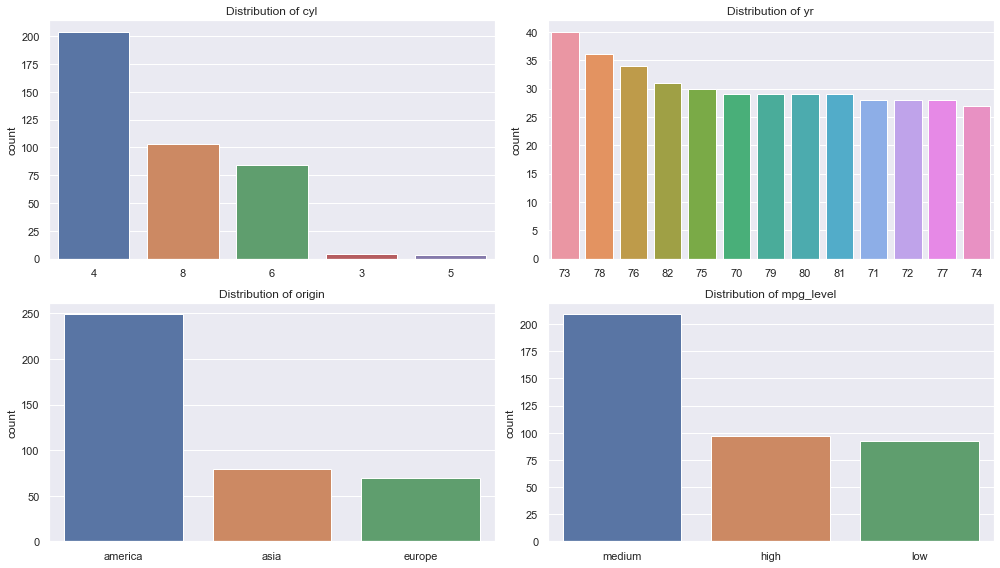

In [16]:
#plotting categorical variables
fig = plt.figure(1, (14, 8))

for i,car in enumerate(car_cat.columns):
    ax = plt.subplot(2,2,i+1)
    sns.countplot(car_cat[car], order=car_cat[car].value_counts().index)
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {car}')
    plt.tight_layout()

plt.show()

American 4 cylinder cars produced in 1973 with medium mpg level seem to dominate the dateset

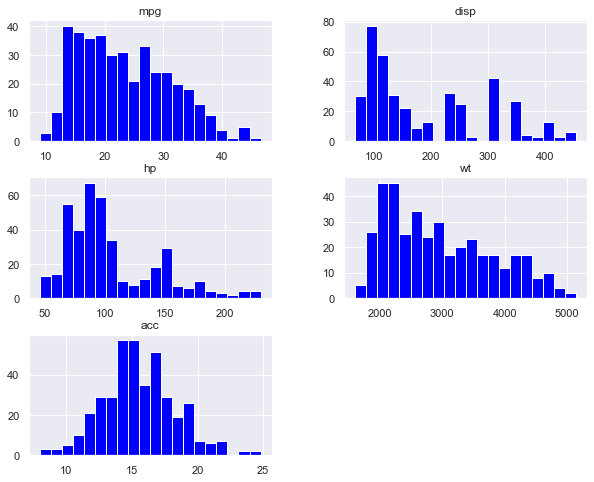

In [17]:
#plot histograms
car_num.hist(bins = 20, figsize = (10, 8), color = 'blue')
plt.show()

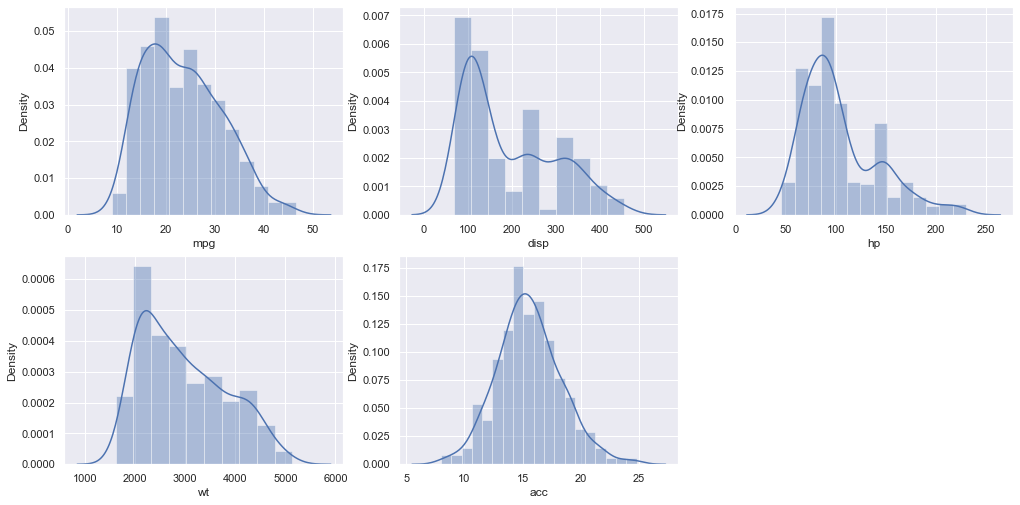

In [18]:
#plot density
plt.figure(figsize=(17, 13))
col = 1
for i in car_num.columns:
    plt.subplot(3, 3, col)
    sns.distplot(car_num[i], color = 'b')
    col += 1 

Displacement and Horsepower seem to be skewed to the right.

In [19]:
#joining the categorical and numerical variables
car=pd.concat([car_cat,car_num],axis=1)

In [20]:
#checking for attribute type
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cyl        398 non-null    int64  
 1   yr         398 non-null    int64  
 2   origin     398 non-null    object 
 3   mpg_level  398 non-null    object 
 4   mpg        398 non-null    float64
 5   disp       398 non-null    float64
 6   hp         398 non-null    float64
 7   wt         398 non-null    int64  
 8   acc        398 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [21]:
#create dummy varibale for mpg_level and origin and creating a seperate datset for k-means and heirarchical clustering
car = pd.get_dummies(car, columns=['origin'])
car = pd.get_dummies(car, columns=['mpg_level'])
car.head()
carH=car.copy()
carK=car.copy()

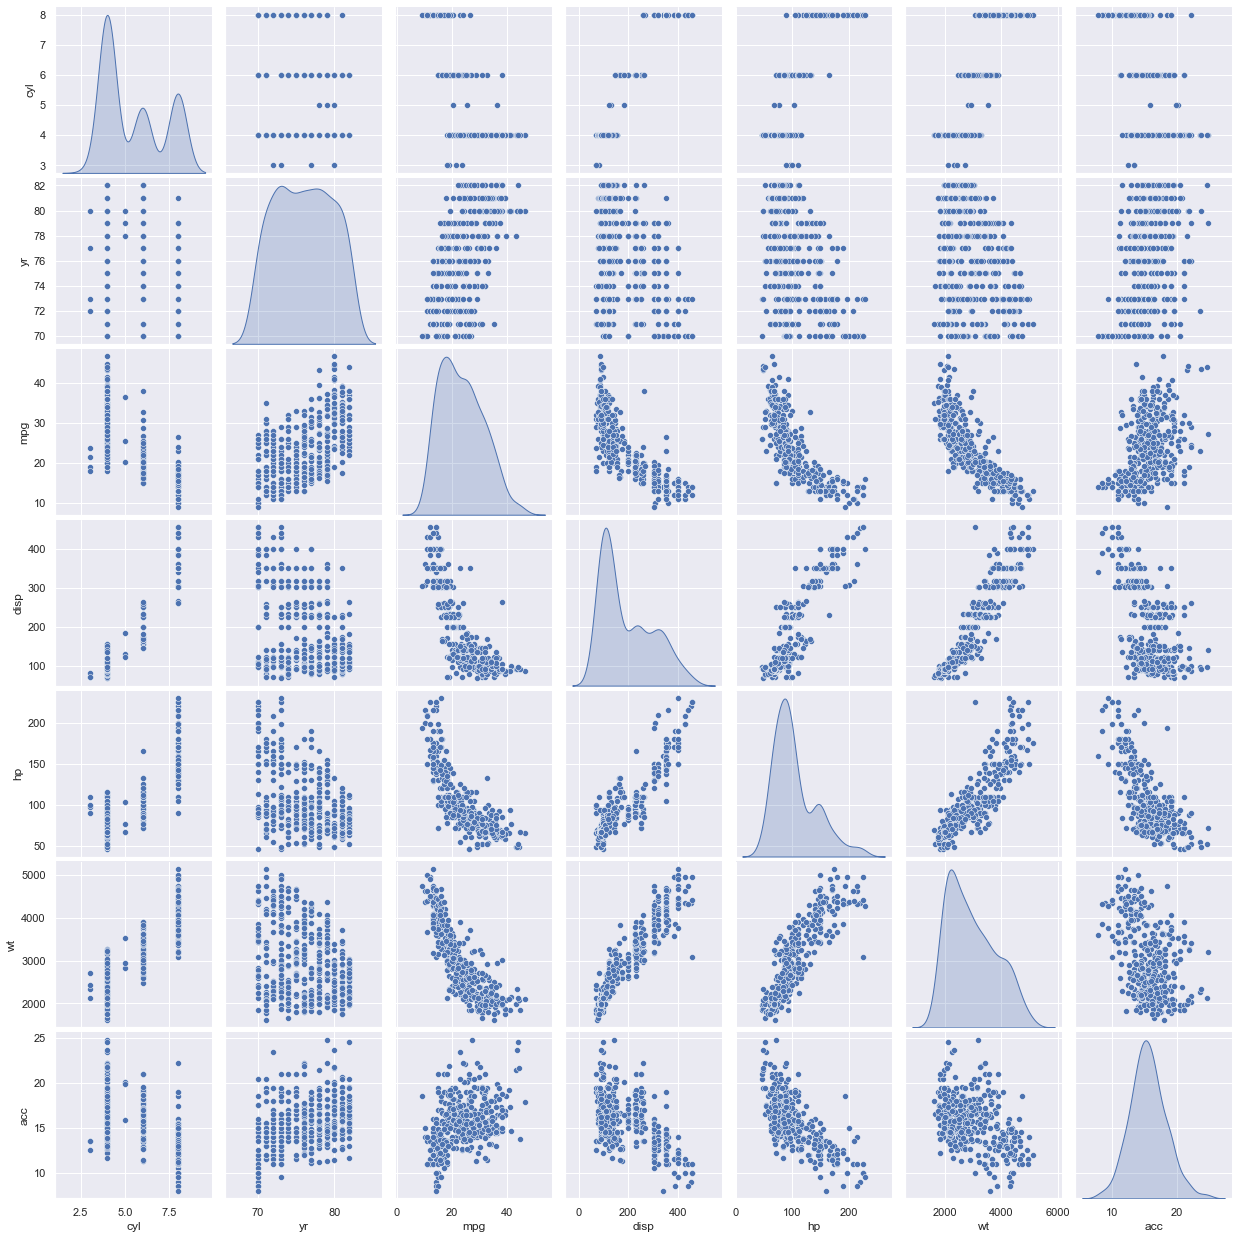

In [22]:
#pair plot for the numeric attributes
car_attr = car.iloc[:, 0:7]
sns.pairplot(car_attr, diag_kind='kde');

There appears to be a linear relationship between the variables.

In [23]:
#dropping the created dummy variable
car2=car.drop(['origin_america','origin_asia','origin_europe','mpg_level_high','mpg_level_low','mpg_level_medium'],axis=1)

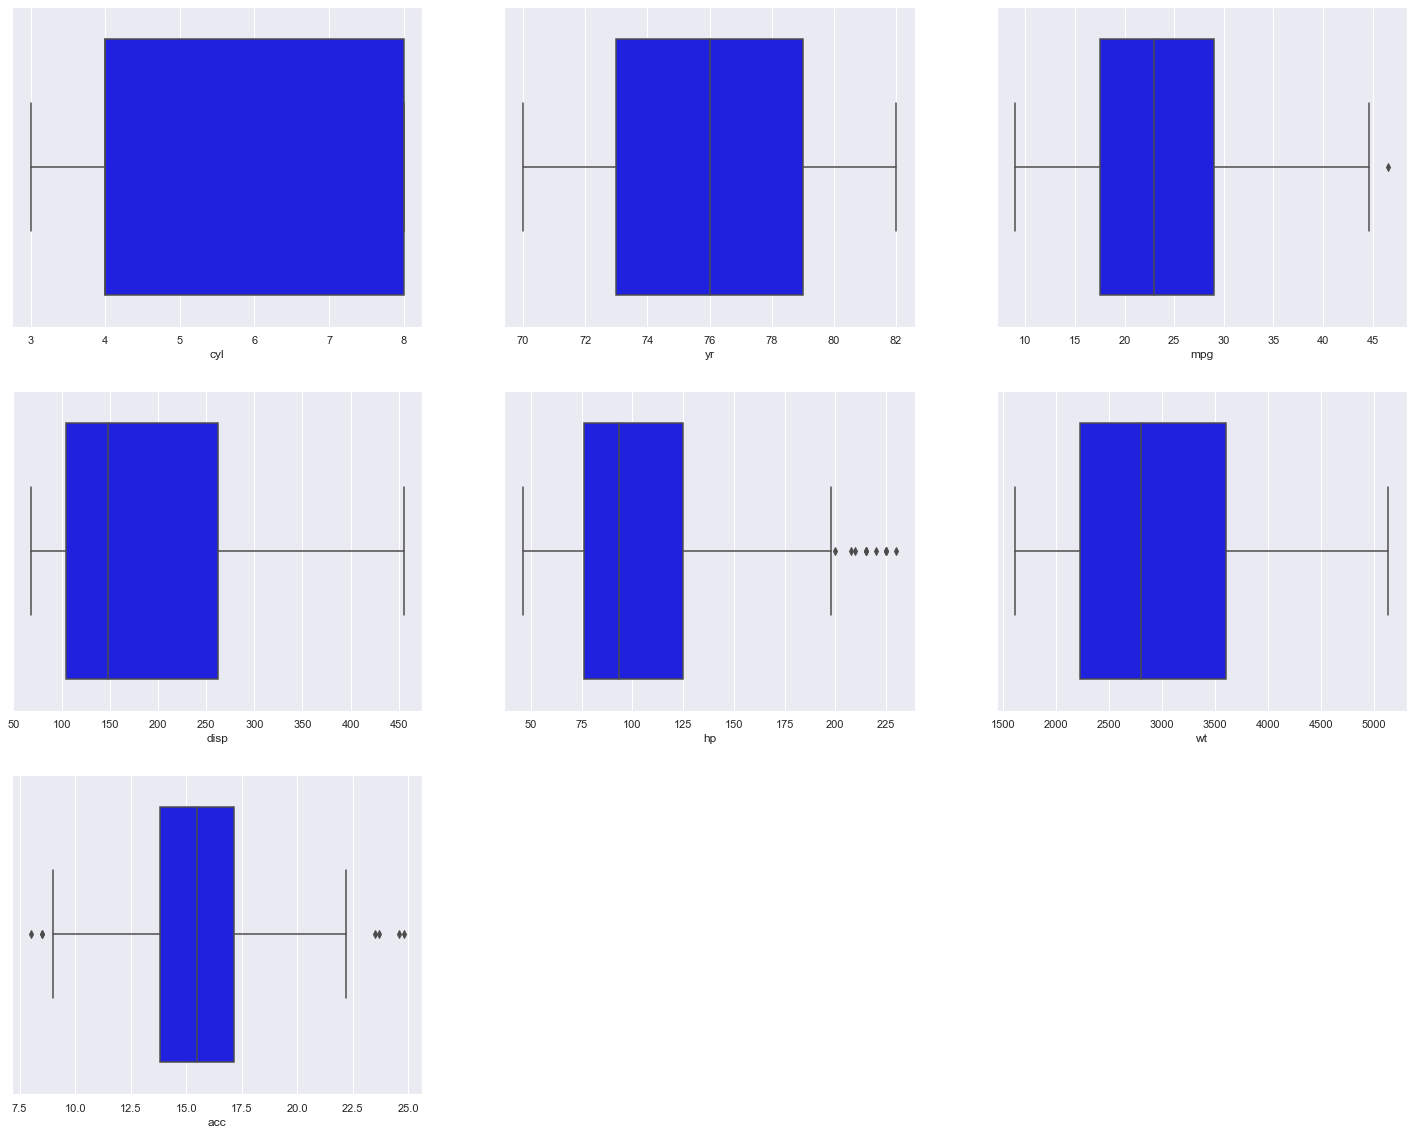

In [24]:
#checking of outliers
plt.figure(figsize=(25, 20))
col = 1
for i in car2.columns:
    plt.subplot(3, 3, col)
    sns.boxplot(car2[i],color='blue')
    col += 1

In [25]:
#replacing outliers with IQR (Q1 and Q3 +-1.5*IQR)
IQR1 = stats.iqr(car2['hp'], interpolation = 'midpoint')
IQR2 = stats.iqr(car2['acc'], interpolation = 'midpoint')

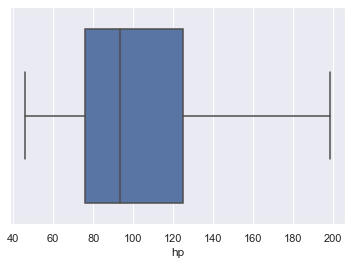

In [26]:
#Horsepower after imputing outliers
Q3 = car2['hp'].quantile(0.75)
car2['hp'] = np.where(car2["hp"] >(Q3+1.5*IQR1), 198.5,car2['hp'])
sns.boxplot(car2['hp']);

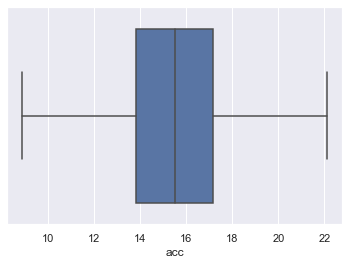

In [27]:
#accelaration after imputing outliers
Q1 = car2['acc'].quantile(0.25)
Q31=car2['acc'].quantile(0.75)
car2['acc'] = np.where(car2["acc"] >(Q31+1.5*IQR2),22.10 ,car2['acc'])
car2['acc'] = np.where(car2["acc"] <(Q1-1.5*IQR2),(Q1-1.5*IQR2),car2['acc'])
sns.boxplot(car2['acc']);

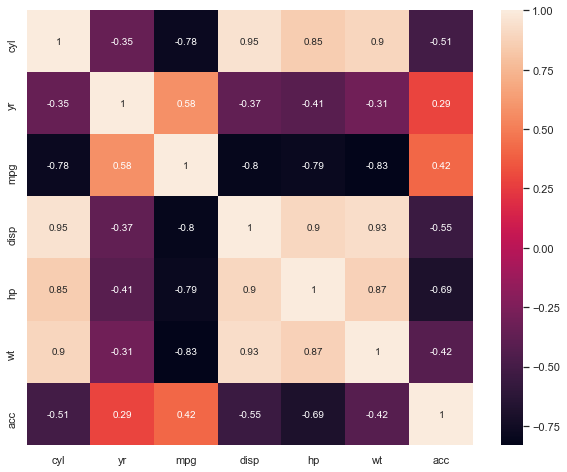

In [28]:
#checking for correlation
plt.figure(figsize=(10,8))
corr=car2.corr()
sns.heatmap(corr,annot=True);

Except "yr" most of the variable are correlated with each other.

# Heirarchical Clustering

In [29]:
#separating numeric variables
cc = car.iloc[:,0:7] 
cc.head()

,cyl,yr,mpg,disp,hp,wt,acc
0,8,70,18.0,307.0,130.0,3504,12.0
1,8,70,15.0,350.0,165.0,3693,11.5
2,8,70,18.0,318.0,150.0,3436,11.0
3,8,70,16.0,304.0,150.0,3433,12.0
4,8,70,17.0,302.0,140.0,3449,10.5


In [30]:
#scaling the variable
cc_z = cc.apply(zscore)
cc_z.head()

,cyl,yr,mpg,disp,hp,wt,acc
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117


In [31]:
#calculating pairwise distance using average linkage method
link_method = linkage(cc_z.iloc[:,0:7], method = 'average')

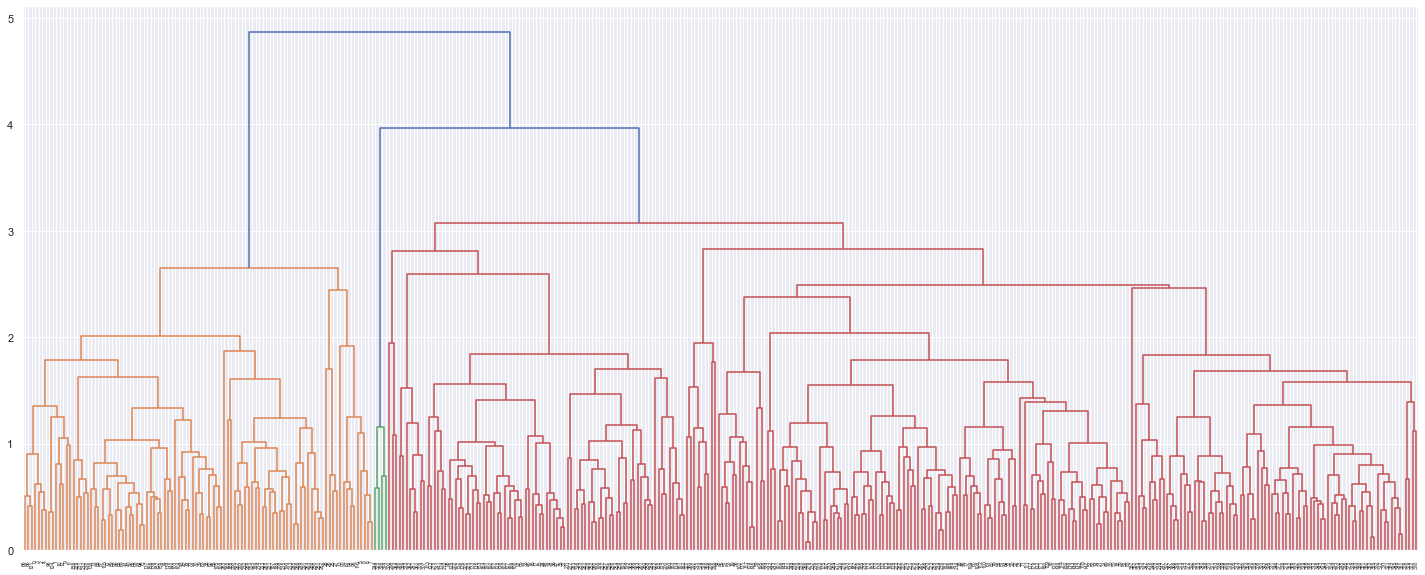

In [32]:
#plotting the H-cluster
plt.figure(figsize=(25, 10))
dendrogram(link_method)
plt.show()

Appers to be to much of a visual clutter, we'll go ahead and cut down the dendrogram to give us 2 clusters/groups.

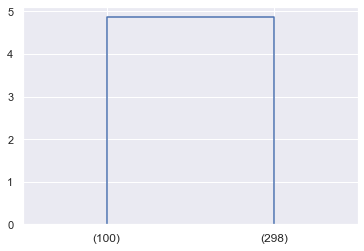

In [33]:
# dendrogram function to arrive at dendrogram
dendrogram(
    link_method,
    truncate_mode='lastp',  
    p=2,  
)
plt.show()

In [34]:
#vieweing the clusters formed
clusters = fcluster(link_method, 2, criterion='maxclust')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,

In [35]:
#attaching the clusters formed to the scaled data
cc_z['clusters_H'] = clusters
cc_z.head()

,cyl,yr,mpg,disp,hp,wt,acc,clusters_H
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498,1
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038,1
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577,1
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498,1
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117,1


In [36]:
#vieweing the distribution of clusters
cc_z.clusters_H.value_counts().sort_index()

1    100
2    298
Name: clusters_H, dtype: int64

In [37]:
#attaching the clusters formed to the original data
cc['clusters_H']=clusters
carH['clusters_H']=clusters
cc.head()

,cyl,yr,mpg,disp,hp,wt,acc,clusters_H
0,8,70,18.0,307.0,130.0,3504,12.0,1
1,8,70,15.0,350.0,165.0,3693,11.5,1
2,8,70,18.0,318.0,150.0,3436,11.0,1
3,8,70,16.0,304.0,150.0,3433,12.0,1
4,8,70,17.0,302.0,140.0,3449,10.5,1


In [38]:
#create a new data set named Hclus
Hclus=cc
Hclus.head()

,cyl,yr,mpg,disp,hp,wt,acc,clusters_H
0,8,70,18.0,307.0,130.0,3504,12.0,1
1,8,70,15.0,350.0,165.0,3693,11.5,1
2,8,70,18.0,318.0,150.0,3436,11.0,1
3,8,70,16.0,304.0,150.0,3433,12.0,1
4,8,70,17.0,302.0,140.0,3449,10.5,1


In [39]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('clusters_H').mean()
aggdata['Freq']=cc.clusters_H.value_counts().sort_index()
aggdata

,cyl,yr,mpg,disp,hp,wt,acc,Freq
clusters_H,,,,,,,,
1,7.980000,73.740000,14.684000,345.470000,160.400000,4121.560000,12.702000,100
2,4.607383,76.771812,26.477852,142.404362,85.479866,2584.137584,16.529866,298


Clearly shows two disting group with a difference in average between the clusters and variables.

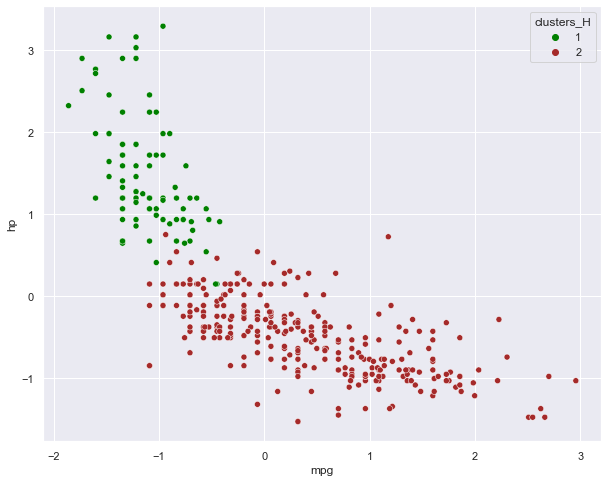

In [40]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="clusters_H",
              data=cc_z, 
                    palette=['green','brown']);

# K-Means Clustering

In [41]:
#seperating the numeric values
cc = car.iloc[:,0:7] 
cc_z1 = cc.apply(zscore)
cc_z1.head()

,cyl,yr,mpg,disp,hp,wt,acc
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117


In [42]:
#calculating the within sum of squares
wss =[] 
for i in range(1,5):
    KM = KMeans(n_clusters=i)
    KM.fit(cc_z1)
    wss.append(KM.inertia_)
wss

[2785.9999999999995, 1294.8418950727323, 946.019790855379, 738.3923281527318]

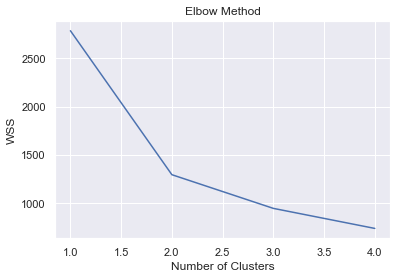

In [43]:
#plotting the WSS against the number of cluster to come up with optimal number of clusters using Elbow-method
plt.plot(range(1,5), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");

In [44]:
#using 2 centroids for clustering
k_means = KMeans(n_clusters = 2)
k_means.fit(cc_z1)
labels = k_means.labels_

In [45]:
# Calculating silhouette_score
silhouette_score(cc_z1,labels)

0.48235946103916116

In [46]:
#calculating silhouette score for different centroids
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}


silhouette_coefficients = []

 # Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cc_z1)
    score = silhouette_score(cc_z1,kmeans.labels_)
    silhouette_coefficients.append(score)

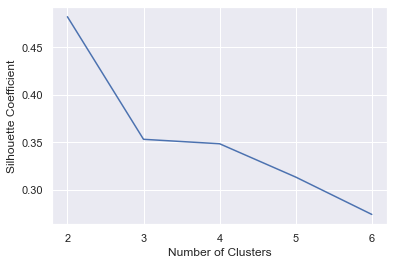

In [47]:
#plotting silhouette score for different centroids
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [48]:
#attaching the labels to the datasets
cc["cluster_K"] = labels
carK['cluster_K']=labels
Kclus=cc
Kclus.head()

,cyl,yr,mpg,disp,hp,wt,acc,cluster_K
0,8,70,18.0,307.0,130.0,3504,12.0,1
1,8,70,15.0,350.0,165.0,3693,11.5,1
2,8,70,18.0,318.0,150.0,3436,11.0,1
3,8,70,16.0,304.0,150.0,3433,12.0,1
4,8,70,17.0,302.0,140.0,3449,10.5,1


In [49]:
#vieweing the distribution of clusters
cc.cluster_K.value_counts().sort_index()

0    293
1    105
Name: cluster_K, dtype: int64

In [50]:
#attaching the clsuters to the scaled data
cc_z1["cluster_K"] = labels
cc_z1.head()

,cyl,yr,mpg,disp,hp,wt,acc,cluster_K
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498,1
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038,1
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577,1
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498,1
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117,1


In [51]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('cluster_K').mean()
aggdata['Freq']=cc.cluster_K.value_counts().sort_index()
aggdata

,cyl,yr,mpg,disp,hp,wt,acc,Freq
cluster_K,,,,,,,,
0,4.569966,76.822526,26.619113,140.250853,85.061433,2567.860068,16.535836,293
1,7.923810,73.742857,14.851429,341.809524,158.000000,4093.771429,12.867619,105


Clearly shows two disting group with a difference in average between the clusters and variables

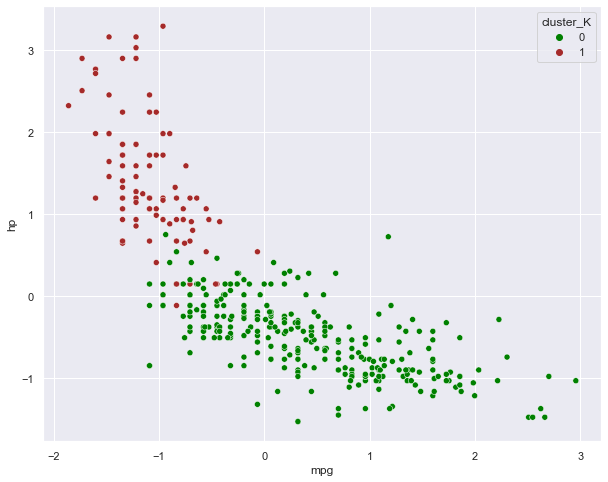

In [52]:
#plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="cluster_K",
              data=cc_z1, 
                    palette=['green','brown']);

In [53]:
carH.clusters_H.value_counts().sort_index()

1    100
2    298
Name: clusters_H, dtype: int64

In [54]:
carK.cluster_K.value_counts().sort_index()

0    293
1    105
Name: cluster_K, dtype: int64

In [55]:
carH.shape

(398, 14)

In [56]:
carK.shape

(398, 14)

In [57]:
car.head()

,cyl,yr,mpg,disp,hp,wt,acc,origin_america,origin_asia,origin_europe,mpg_level_high,mpg_level_low,mpg_level_medium
0,8,70,18.0,307.0,130.0,3504,12.0,1,0,0,0,0,1
1,8,70,15.0,350.0,165.0,3693,11.5,1,0,0,0,1,0
2,8,70,18.0,318.0,150.0,3436,11.0,1,0,0,0,0,1
3,8,70,16.0,304.0,150.0,3433,12.0,1,0,0,0,1,0
4,8,70,17.0,302.0,140.0,3449,10.5,1,0,0,0,0,1


# Linear Regression on the original dataset.

In [58]:
X = car.drop(['mpg','origin_europe','mpg_level_low'], axis=1)
# the dependent variable
y = car[['mpg']]

In [59]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)

In [60]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [61]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -0.5134441386218385
The coefficient for yr is 0.44346504291168337
The coefficient for disp is 0.010688858394646908
The coefficient for hp is 0.010315514536314019
The coefficient for wt is -0.004538788568737129
The coefficient for acc is 0.19183425608862725
The coefficient for origin_america is -1.7306209513688977
The coefficient for origin_asia is -0.8976724344009391
The coefficient for mpg_level_high is 8.552374663817035
The coefficient for mpg_level_medium is 1.5941218694850414


In [62]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -1.663571756865423


In [63]:
regression_model.score(X_train, y_train)

0.8967703023839787

In [64]:
O=regression_model.score(X_test, y_test)
O

0.9037421476349171

# Linear Regression on data with K means cluster.

In [65]:
#renaming the cluster labels to light and heavy vehicles and creating dummy variables of it
carK['cluster_K']=carK['cluster_K'].astype('category')
carK['cluster_K'] = carK['cluster_K'].replace({1: 'heavy', 0: 'light'})
carK = pd.get_dummies(carK, columns=['cluster_K'])

In [66]:
carK.head()

,cyl,yr,mpg,disp,hp,wt,acc,origin_america,origin_asia,origin_europe,mpg_level_high,mpg_level_low,mpg_level_medium,cluster_K_heavy,cluster_K_light
0,8,70,18.0,307.0,130.0,3504,12.0,1,0,0,0,0,1,1,0
1,8,70,15.0,350.0,165.0,3693,11.5,1,0,0,0,1,0,1,0
2,8,70,18.0,318.0,150.0,3436,11.0,1,0,0,0,0,1,1,0
3,8,70,16.0,304.0,150.0,3433,12.0,1,0,0,0,1,0,1,0
4,8,70,17.0,302.0,140.0,3449,10.5,1,0,0,0,0,1,1,0


In [67]:
X = carK.drop(['mpg','origin_europe','mpg_level_low','cluster_K_light'], axis=1)
# the dependent variable
y = carK[['mpg']]

In [68]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

In [69]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [70]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -1.194599564477799
The coefficient for yr is 0.4318651041505992
The coefficient for disp is 0.017477496279110376
The coefficient for hp is -0.01013804583590548
The coefficient for wt is -0.0040684301693864056
The coefficient for acc is 0.1856482874625012
The coefficient for origin_america is -1.6918315494304048
The coefficient for origin_asia is -0.7407779192303025
The coefficient for mpg_level_high is 9.283120939156872
The coefficient for mpg_level_medium is 2.2500017142312445
The coefficient for cluster_K_heavy is 2.5115140143384727


In [71]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 1.204146806717251


In [72]:
regression_model.score(X_train, y_train)

0.8942370456543635

In [73]:
K=regression_model.score(X_test, y_test)
K

0.9117893808052381

# Linear Regression on data with H-clusters.

In [74]:
#renaming the cluster labels to light and heavy vehicles and creating summy variable of it
carH['clusters_H']=carH['clusters_H'].astype('category')
carH['clusters_H'] = carH['clusters_H'].replace({1: 'heavy', 2: 'light'})
carH = pd.get_dummies(carH, columns=['clusters_H'])

In [75]:
X = carH.drop(['mpg','origin_europe','mpg_level_low','clusters_H_light'], axis=1)
# the dependent variable
y = carH[['mpg']]

In [76]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

In [77]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [78]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -1.0104832432577142
The coefficient for yr is 0.4475417357550146
The coefficient for disp is 0.01511520052461407
The coefficient for hp is -0.013301584387234512
The coefficient for wt is -0.004264179780672395
The coefficient for acc is 0.11805139164484812
The coefficient for origin_america is -2.1174569315391127
The coefficient for origin_asia is -1.3974915348558072
The coefficient for mpg_level_high is 8.565948239298272
The coefficient for mpg_level_medium is 1.6577250698582815
The coefficient for clusters_H_heavy is 2.038974468807401


In [79]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 2.5727293182332573


In [80]:
regression_model.score(X_train, y_train)

0.8988409890950728

In [81]:
H=regression_model.score(X_test, y_test)
H

0.9010238373846695

In [82]:
modellists = []
modellists.append(['Linear Regression on Original Data set', O*100])
modellists.append(['Linear Regression with K means clusters', K*100])
modellists.append(['Linear Regression with Heirarchical clusters', H*100])
mdl_df = pd.DataFrame(modellists, columns = ['Model','r^2 on Test'])
mdl_df

,Model,r^2 on Test
0,Linear Regression on Original Data set,90.374215
1,Linear Regression with K means clusters,91.178938
2,Linear Regression with Heirarchical clusters,90.102384


# Summary

K-means appears to explain the highest variation in the datset, but with a difference of only 1% when compared with other models, to get more clarity a larger dataset may be used, since this is a dataset of used cars it doesn't give us how many previous owners has the cars seen which might be helful variable,the gender of the previous owners, the reason/purpose that the cars were being used is also an important factor which the dataset doen't capture. With the above mentioned features it may be possible to get a higher accuracy or explainability of the models and its variables.

# Part Two

In [1]:
import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [2]:
#importing the data
wi=pd.ExcelFile('Part2 - Company.xlsx',engine='openpyxl')
wi.sheet_names
wi = wi.parse("Sheet1")
wi.head()

,A,B,C,D,Quality
0,47,27,45,108,Quality A
1,174,133,134,166,Quality B
2,159,163,135,131,NaN
3,61,23,3,44,Quality A
4,59,60,9,68,Quality A


In [3]:
row, column = wi.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 61 rows and 5 columns


In [4]:
#make a copy of the data
wi1=wi.copy()

In [5]:
#dropping the target variable
wi=wi.drop('Quality',axis=1)

In [6]:
#checking for data types
print('The data type of each attribute: \n')
wi1.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   A        61 non-null     int64 
 1   B        61 non-null     int64 
 2   C        61 non-null     int64 
 3   D        61 non-null     int64 
 4   Quality  43 non-null     object
dtypes: int64(4), object(1)
memory usage: 2.5+ KB


In [7]:
print('The Target Variable has set 18 missing values \n')
wi1.isnull().sum()

The Target Variable has set 18 missing values 



A           0
B           0
C           0
D           0
Quality    18
dtype: int64

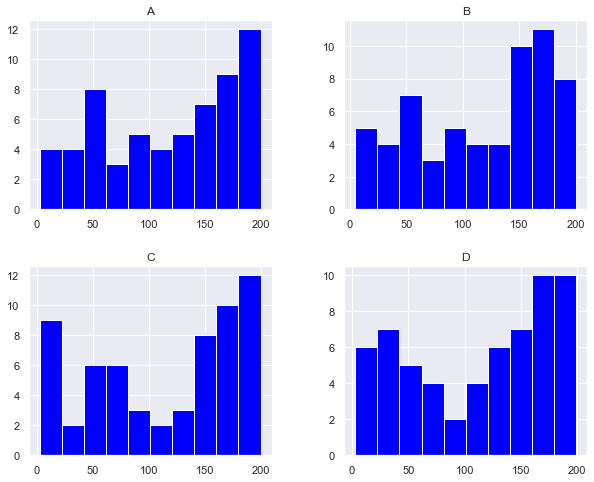

In [8]:
#checking the distribution of the data points
wi.hist(bins = 10, figsize = (10, 8), color = 'blue')
plt.show()

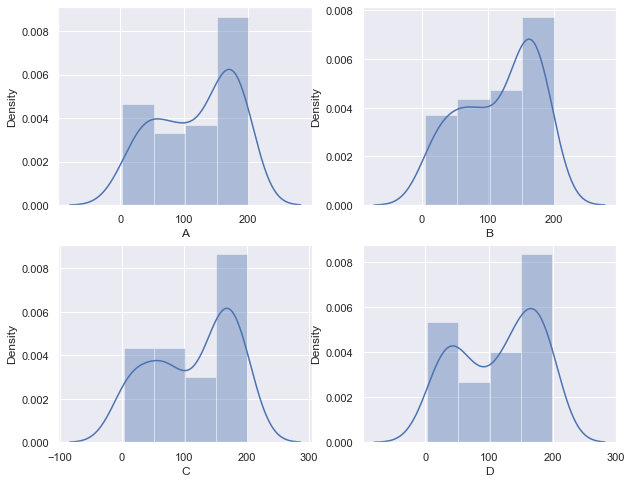

In [9]:
#checking for the density of the variable
plt.figure(figsize=(10, 8))
col = 1
for i in wi.columns:
    plt.subplot(2, 2, col)
    sns.distplot(wi[i], color = 'b')
    col += 1 

The chemical compositions are on the same scales between 0 to 200.

In [10]:
#scaling the numeric variables
w1 = wi.apply(zscore)
w1.head()

,A,B,C,D
0,-1.168034,-1.561080,-1.061569,-0.103138
1,0.904992,0.284923,0.306077,0.823013
2,0.660147,0.807376,0.321443,0.264129
3,-0.939512,-1.630740,-1.706975,-1.125099
4,-0.972158,-0.986381,-1.614775,-0.741864


In [11]:
#checking for the distribution of the targrt variables
wi1['Quality'].value_counts()

Quality A    26
Quality B    17
Name: Quality, dtype: int64

In [12]:
#applying kmeans with 2 centroids
k_means = KMeans(n_clusters = 2)
k_means.fit(w1)
labels = k_means.labels_

In [13]:
# Calculating silhouette_score
silhouette_score(w1,labels)

0.6891674125195145

In [14]:
#attaching the cluster labels to the original dataset
wi1["Quality_k"] = labels

In [15]:
#checking for the first 15 observations
wi1.head(15)

,A,B,C,D,Quality,Quality_k
0,47,27,45,108,Quality A,1
1,174,133,134,166,Quality B,0
2,159,163,135,131,NaN,0
3,61,23,3,44,Quality A,1
4,59,60,9,68,Quality A,1
5,153,140,154,199,NaN,0
6,34,28,78,22,Quality A,1
7,191,144,143,154,NaN,0
8,160,181,194,178,Quality B,0
9,145,178,158,141,NaN,0


In [16]:
#renaming the cluster labels
wi1['Quality_k'] = wi1['Quality_k'].replace({1: 'Quality A', 0: 'Quality B'})

In [17]:
#checking for datatypes
wi1.dtypes

A             int64
B             int64
C             int64
D             int64
Quality      object
Quality_k    object
dtype: object

In [18]:
#dropping na rows
wn=wi1.dropna()

In [19]:
#checking for the shape
wn.shape

(43, 6)

In [20]:
#using the cluster labels and actual target labels to check for accuracy
pred = wn['Quality_k']
actual=wn['Quality']

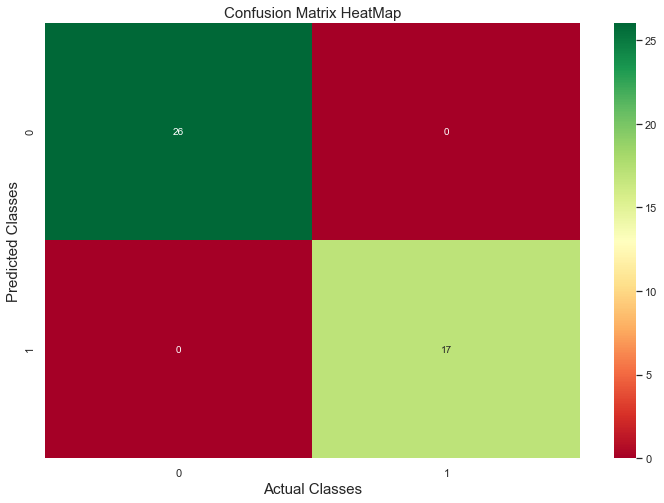

In [21]:
#visualization of confusion matrix in the form of a heatmap
cm= confusion_matrix(actual, pred)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix HeatMap', fontsize = 15);

There appears to be no misclassification when checking it with the non missing target variables and the predicted clusters. Hence the new labels can be used as a target variable.

# Part Three

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn import metrics
%matplotlib inline
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')

# EDA

In [2]:
#import the dataset
ve = pd.read_csv('Part3 - vehicle.csv')
ve.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [3]:
#checking for the dimension of the data
rows, column = ve.shape
print('The dataset contains', rows, 'rows and', column, 'columns.')

The dataset contains 846 rows and 19 columns.


In [4]:
#checking for the data type
print('The data type of each attribute: \n')
ve.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null  

In [5]:
print('Duplicated rows:', ve[ve.duplicated()].shape[0])

Duplicated rows: 0


In [6]:
print('Null Values: \n', ve.isnull().sum())

Null Values: 
 compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64


There are quite a few missing values.

In [7]:
#replacing the missing values with median values
for cols in ve.columns:
    if(cols != 'class'): 
        ve[cols] = ve[cols].fillna(ve[cols].median())

In [8]:
#5-point summary
ve.describe().T

,count,mean,std,min,25%,50%,75%,max
compactness,846.0,93.678487,8.234474,73.0,87.00,93.0,100.00,119.0
circularity,846.0,44.823877,6.134272,33.0,40.00,44.0,49.00,59.0
distance_circularity,846.0,82.100473,15.741569,40.0,70.00,80.0,98.00,112.0
radius_ratio,846.0,168.874704,33.401356,104.0,141.00,167.0,195.00,333.0
pr.axis_aspect_ratio,846.0,61.677305,7.882188,47.0,57.00,61.0,65.00,138.0
max.length_aspect_ratio,846.0,8.567376,4.601217,2.0,7.00,8.0,10.00,55.0
scatter_ratio,846.0,168.887707,33.197710,112.0,147.00,157.0,198.00,265.0
elongatedness,846.0,40.936170,7.811882,26.0,33.00,43.0,46.00,61.0
pr.axis_rectangularity,846.0,20.580378,2.588558,17.0,19.00,20.0,23.00,29.0
max.length_rectangularity,846.0,147.998818,14.515652,118.0,137.00,146.0,159.00,188.0


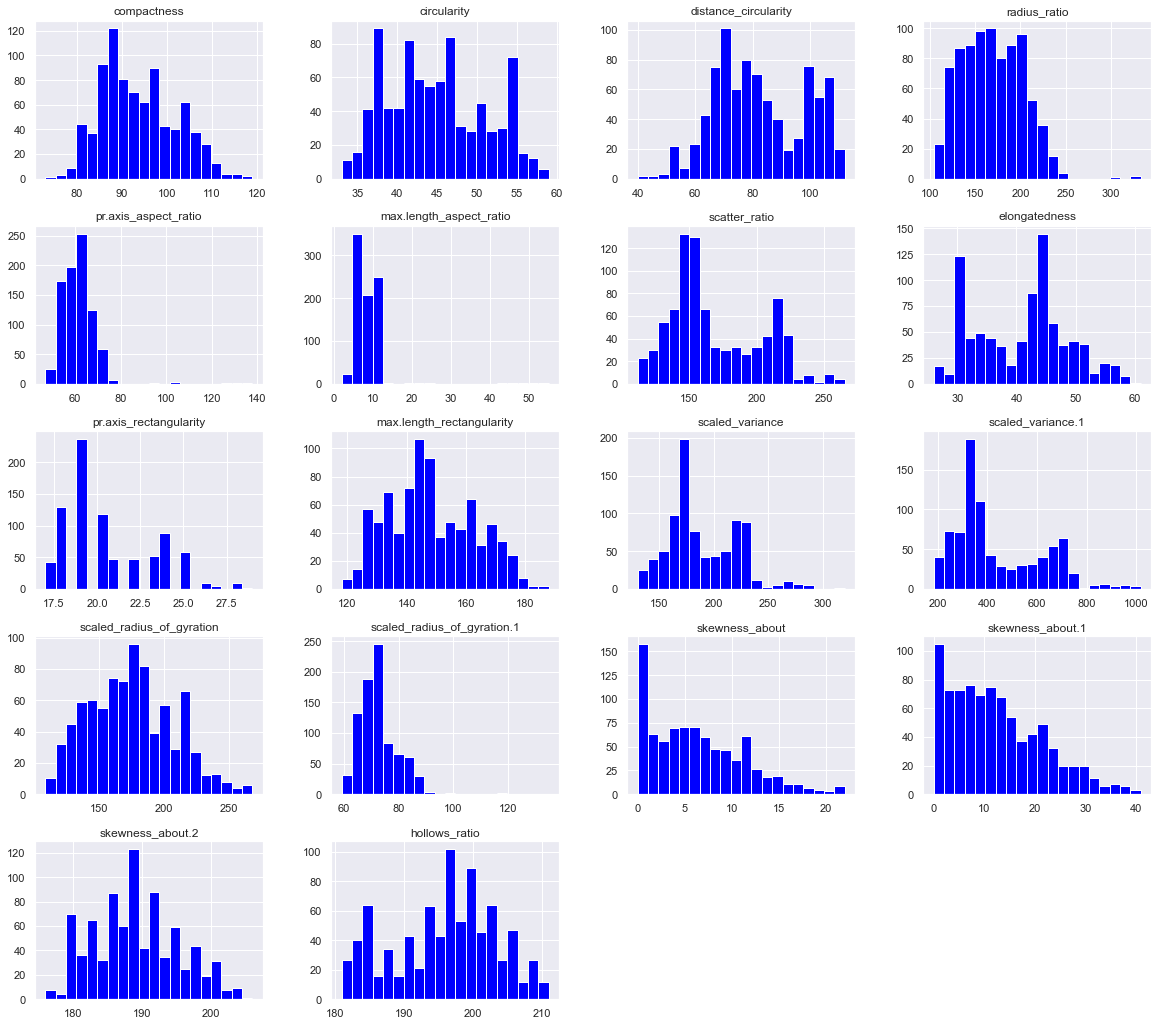

In [9]:
#plotting the distribution of the numerical variables
ve.hist(bins = 20, figsize = (20, 18), color = 'blue')
plt.show()

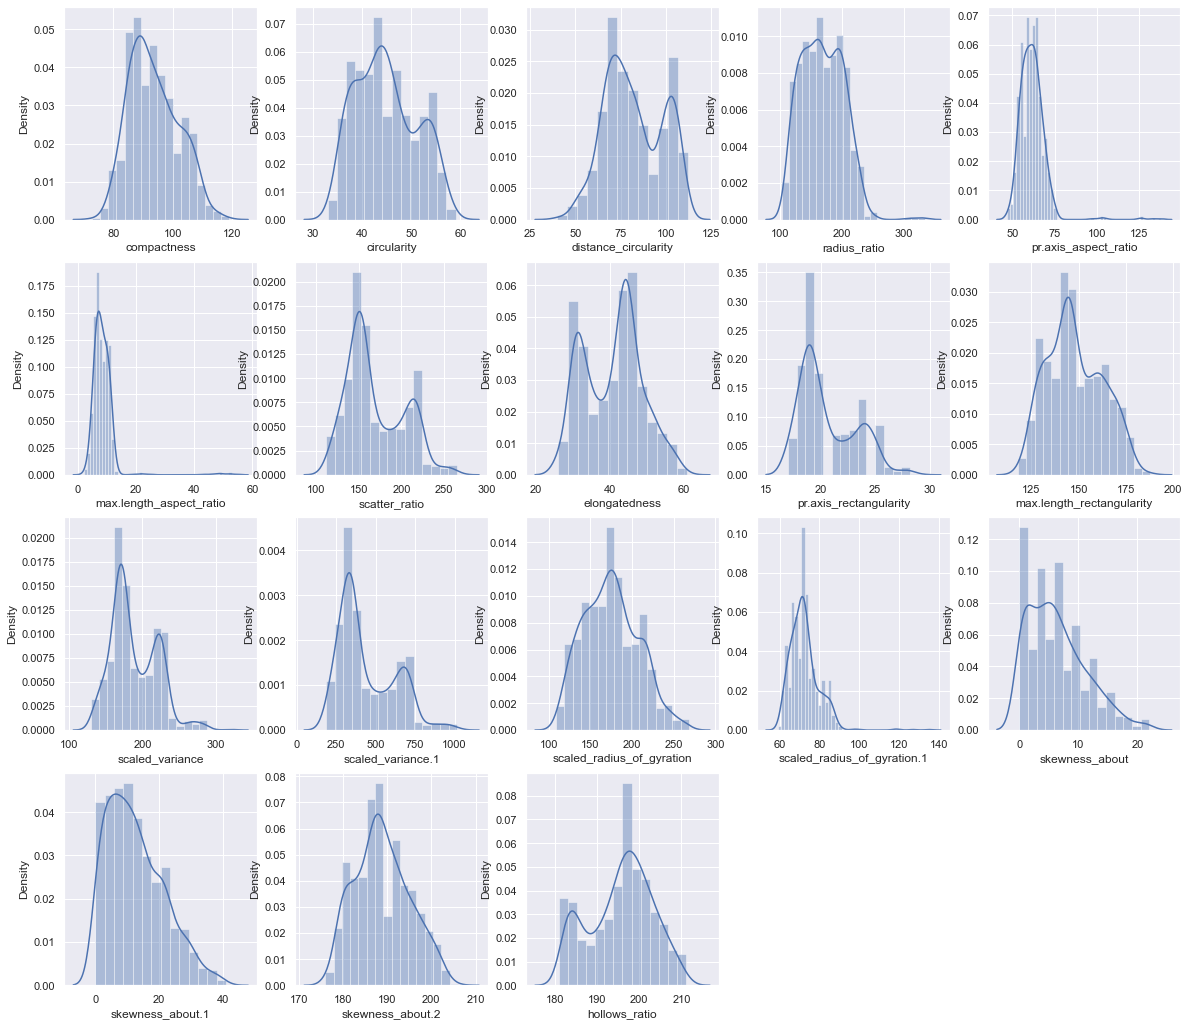

In [10]:
#Density plots
plt.figure(figsize=(20, 18))
col = 1
for i in ve.drop(columns='class').columns:
    plt.subplot(4, 5, col)
    sns.distplot(ve[i], color = 'b')
    col += 1 

Columns have data distributed across multiple scales. Several columns have distributions that are not unimodal (eg.: distance_circularity, hollows_ratio, elongatedness Column skweness_about, skewness_about.1 have data that is right skewed whereas for column skewness_about.2 data is nearly normally distributed. Some columns have long right tail (eg.: pr.axis_aspect_ratio) as evident from the above distplot it is highly likely that they will have outliers.

car    429
bus    218
van    199
Name: class, dtype: int64


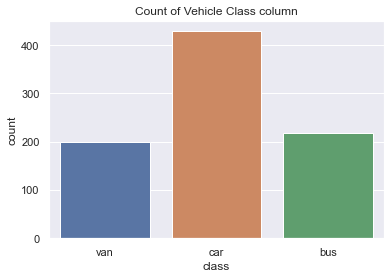

In [11]:
#checking the distribution of the class variable
print(ve['class'].value_counts())
plt.title('Count of Vehicle Class column')
sns.countplot(x = 'class', data = ve);

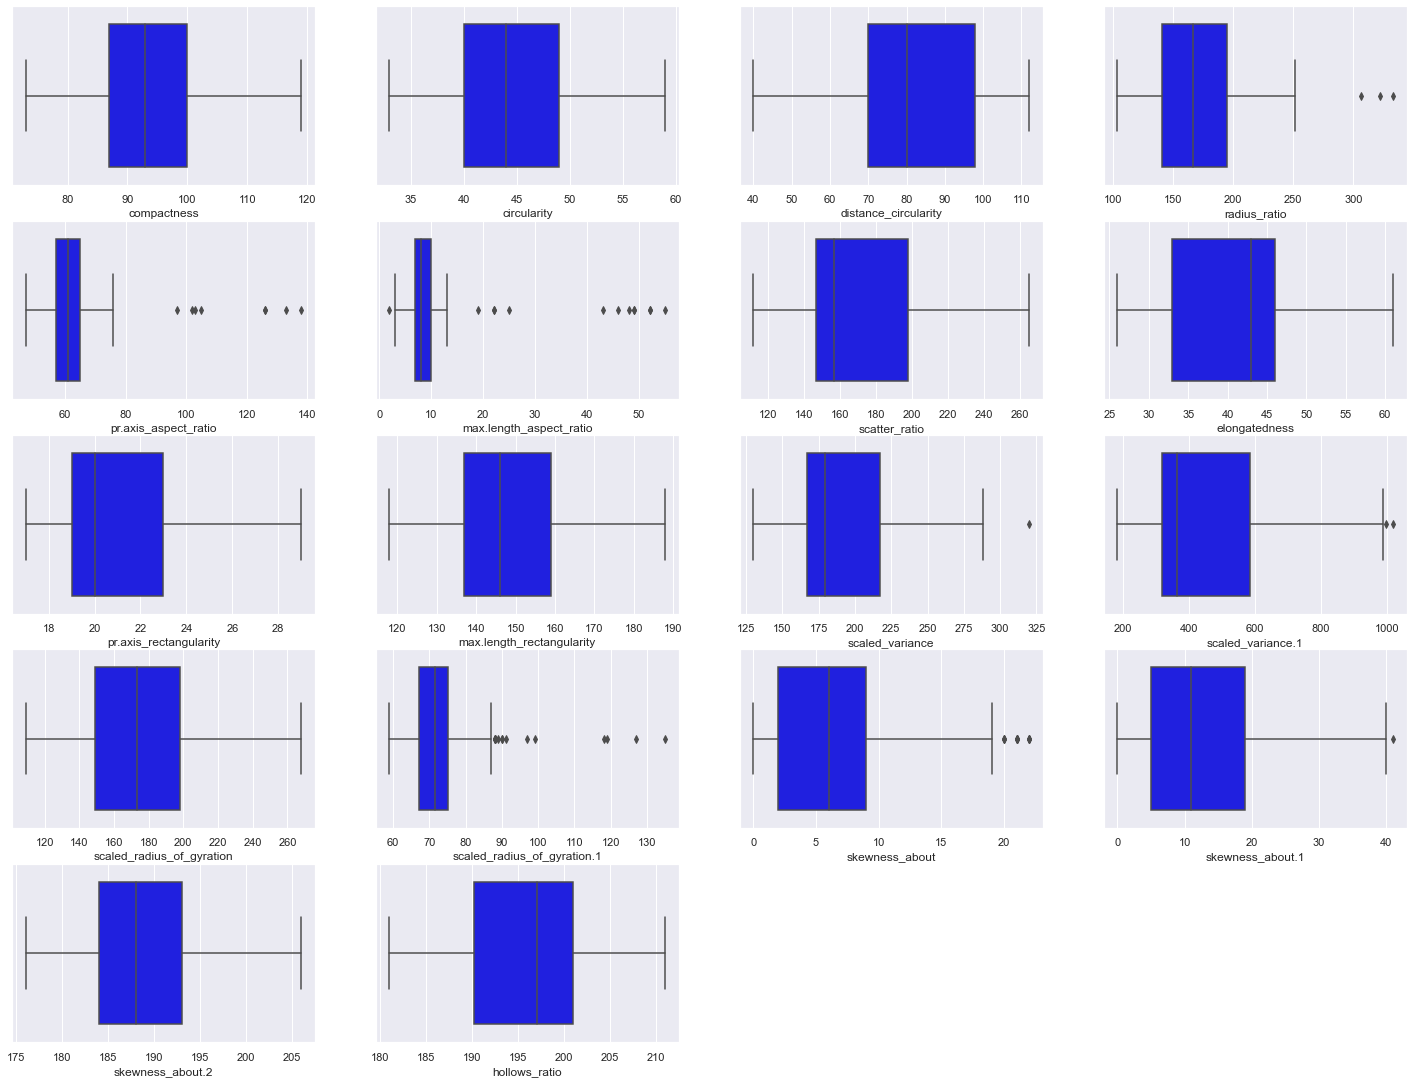

In [12]:
#boxplots for outliers
plt.figure(figsize=(25,23))
col = 1
for i in ve.drop(columns='class').columns:
    plt.subplot(6, 4, col)
    sns.boxplot(ve[i],color='blue')
    col += 1

Above Boxplots reveal that there are outliers in 8 different columns.

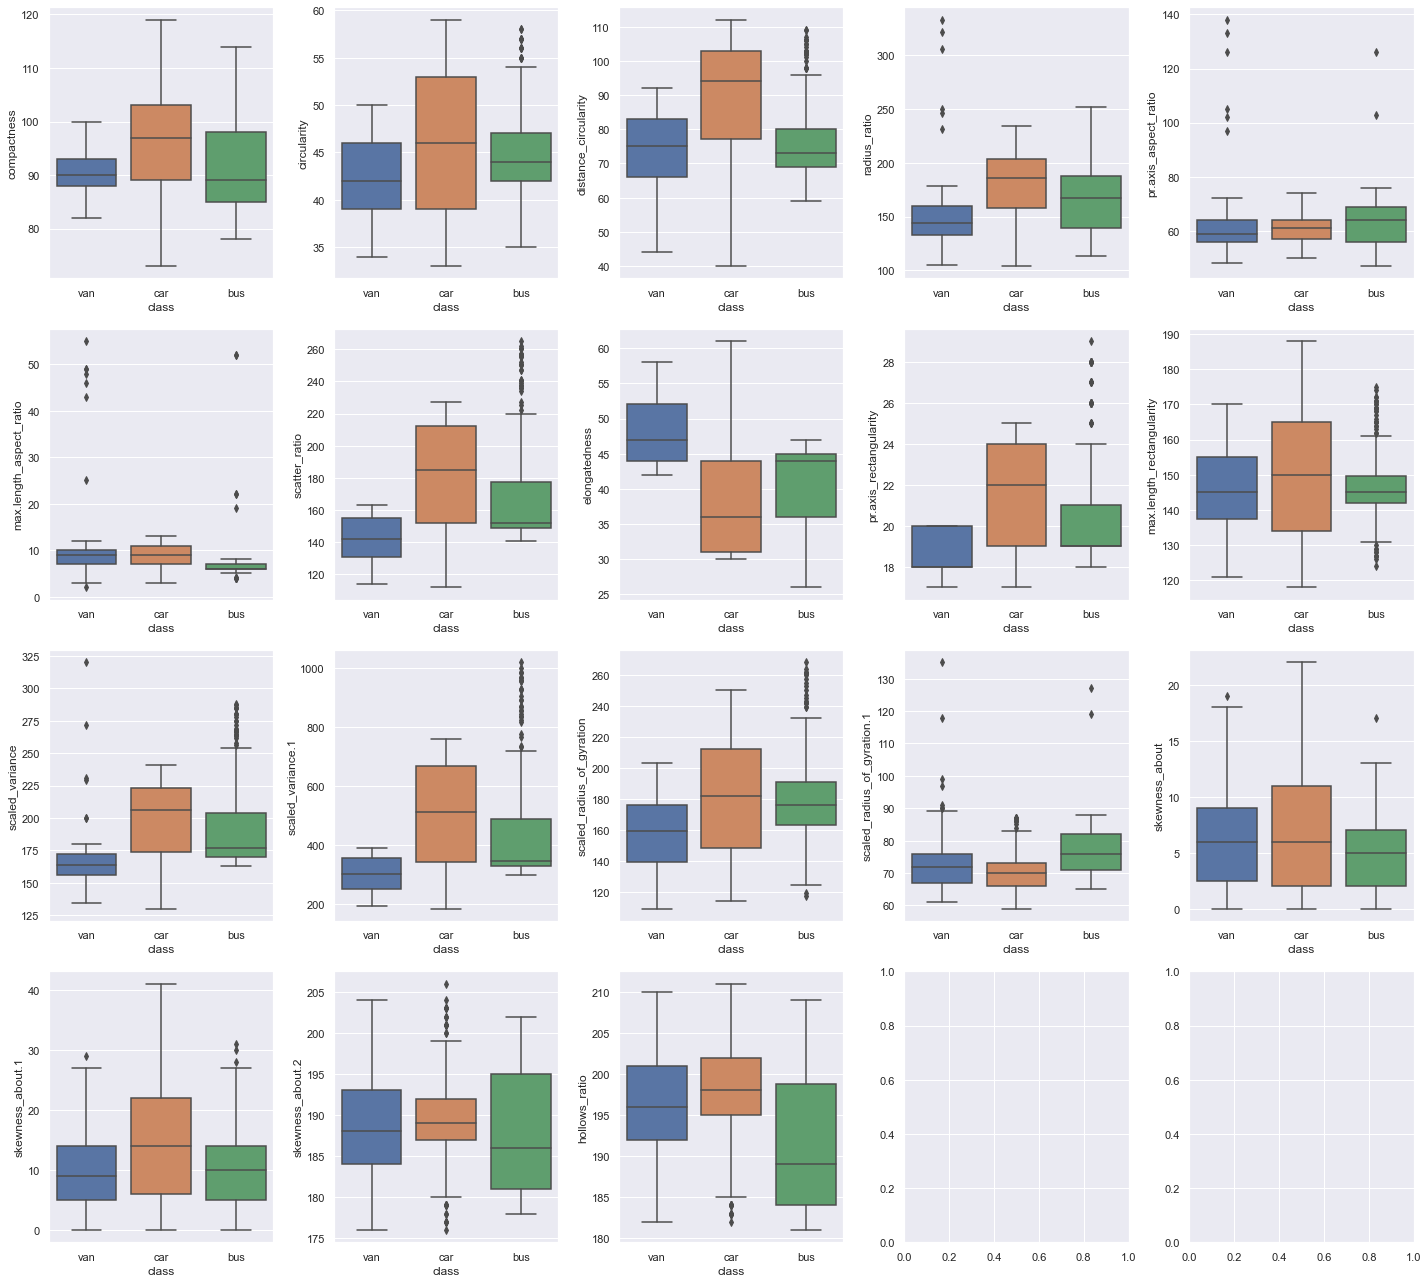

In [13]:
#Boxplots against the class with other numeric variables
fig,axs = plt.subplots(4,5,figsize=(20,18))
sns.boxplot(x="class", y="compactness",data=ve,ax=axs[0,0]);
sns.boxplot(x="class", y="circularity",data=ve,ax=axs[0,1]);
sns.boxplot(x="class", y="distance_circularity",data=ve,ax=axs[0,2]);
sns.boxplot(x="class", y="radius_ratio",data=ve,ax=axs[0,3]);
sns.boxplot(x="class", y="pr.axis_aspect_ratio",data=ve,ax=axs[0,4]);
sns.boxplot(x="class", y="max.length_aspect_ratio",data=ve,ax=axs[1,0]);
sns.boxplot(x="class", y="scatter_ratio",data=ve,ax=axs[1,1]);
sns.boxplot(x="class", y="elongatedness",data=ve,ax=axs[1,2]);
sns.boxplot(x="class", y="pr.axis_rectangularity",data=ve,ax=axs[1,3]);
sns.boxplot(x="class", y="max.length_rectangularity",data=ve,ax=axs[1,4]);
sns.boxplot(x="class", y="scaled_variance",data=ve,ax=axs[2,0]);
sns.boxplot(x="class", y="scaled_variance.1",data=ve,ax=axs[2,1]);
sns.boxplot(x="class", y="scaled_radius_of_gyration",data=ve,ax=axs[2,2]);
sns.boxplot(x="class", y="scaled_radius_of_gyration.1",data=ve,ax=axs[2,3]);
sns.boxplot(x="class", y="skewness_about",data=ve,ax=axs[2,4]);
sns.boxplot(x="class", y="skewness_about.1",data=ve,ax=axs[3,0]);
sns.boxplot(x="class", y="skewness_about.2",data=ve,ax=axs[3,1]);
sns.boxplot(x="class", y="hollows_ratio",data=ve,ax=axs[3,2]);
fig.tight_layout()

There is significant difference between classes when compared with the mean and median with all the numeric attributes.

In [14]:
#find the outliers and replace them by median
for col_name in ve.drop(columns = 'class').columns:
    q1 = ve[col_name].quantile(0.25)
    q3 = ve[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    
    ve.loc[(ve[col_name] < low) | (ve[col_name] > high), col_name] = ve[col_name].median()

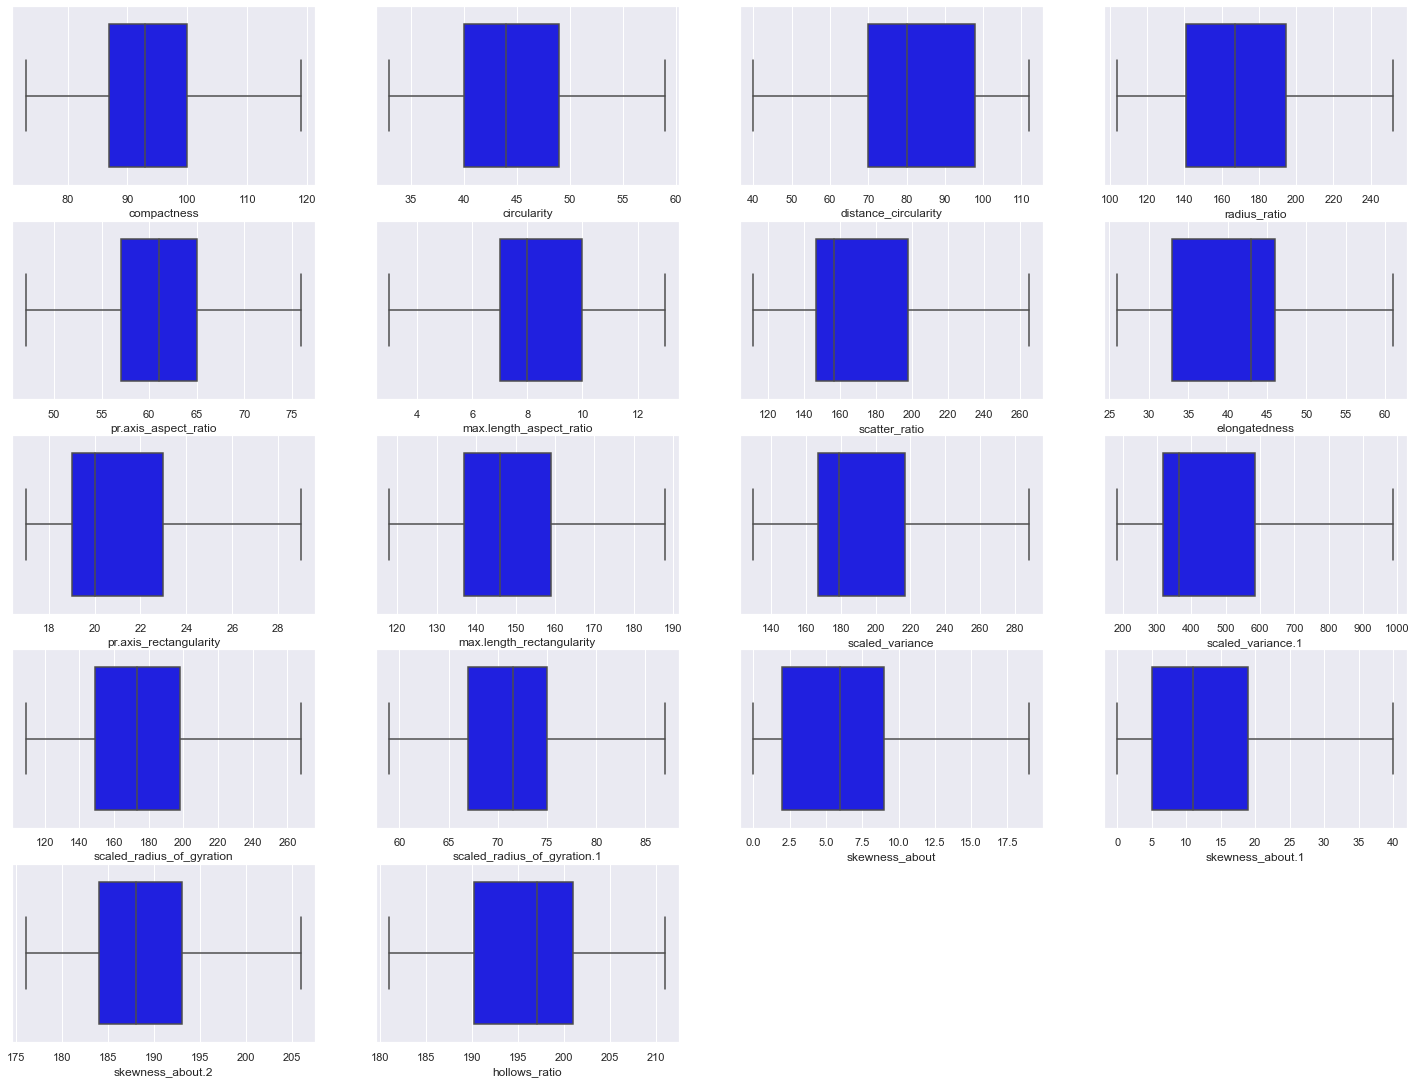

In [15]:
#boxplot after outlier treatment
plt.figure(figsize=(25,23))
col = 1
for i in ve.drop(columns='class').columns:
    plt.subplot(6, 4, col)
    sns.boxplot(ve[i],color='blue')
    col += 1

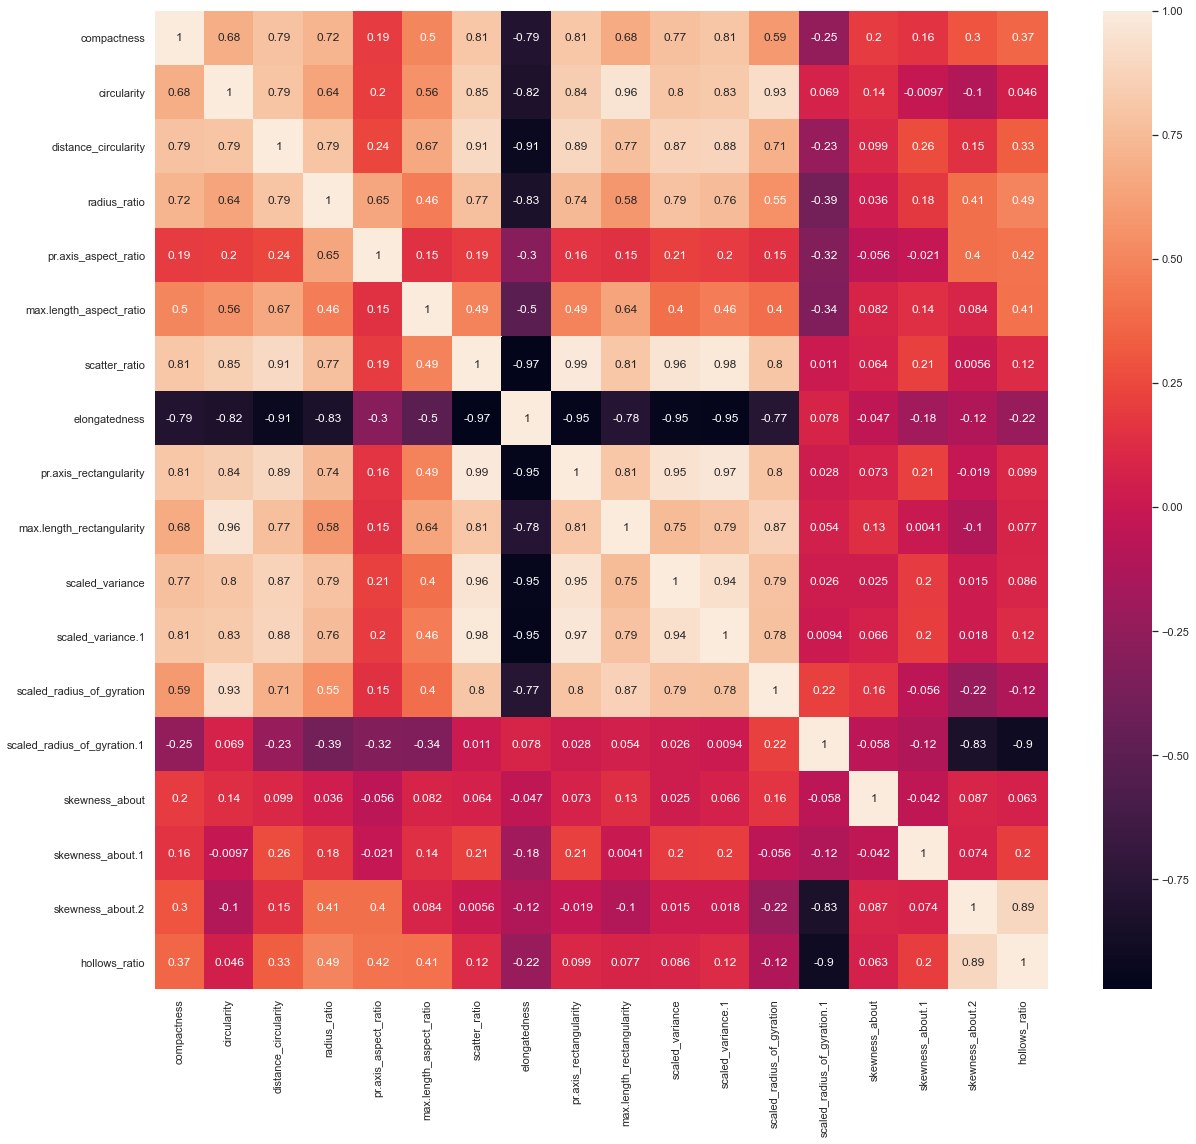

In [16]:
#checking for correlation
plt.figure(figsize=(20,18))
corr=ve.corr()
sns.heatmap(corr,annot=True);

In [17]:
#spliiting the data to check for correlation with the class variable
X = ve.loc[:, ve.columns != 'class']
y = ve['class'].astype('category').cat.codes

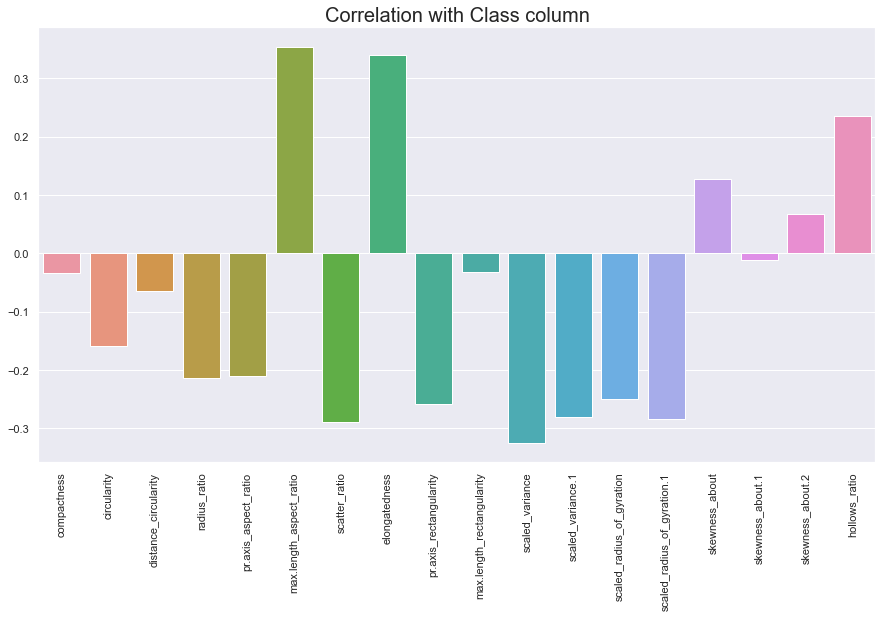

In [18]:
#plotting the correlation with target variable
plt.figure(figsize = (15, 8))
ax=sns.barplot(x=X.columns, y = X.corrwith(y))
sns.barplot(x = X.columns, y = X.corrwith(y))
plt.title('Correlation with Class column', fontsize = 20)
x=plt.setp(ax.get_xticklabels(), rotation=90)

# PCA

In [19]:
#scaling the muerica variables
XScaled=X.apply(zscore)
XScaled.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio
0,0.160580,0.518073,0.057177,0.300945,1.933135,0.912212,-0.207598,0.136262,-0.224342,0.758332,-0.400771,-0.337407,0.285705,-0.315806,-0.032330,0.387162,-0.312012,0.183957
1,-0.325470,-0.623732,0.120741,-0.850666,-0.740596,0.427456,-0.599423,0.520519,-0.610886,-0.344578,-0.594220,-0.618623,-0.513630,0.009122,0.624090,0.161740,0.013265,0.452977
2,1.254193,0.844303,1.519141,1.265808,0.863642,0.912212,1.148719,-1.144597,0.935290,0.689401,1.114582,1.131806,1.392477,0.171586,1.718123,-0.401818,-0.149374,0.049447
3,-0.082445,-0.623732,-0.006386,-0.290423,0.328896,0.427456,-0.750125,0.648605,-0.610886,-0.344578,-0.916635,-0.739145,-1.466683,-1.453054,-0.032330,-0.289106,1.639649,1.529056
4,-1.054545,-0.134387,-0.769150,1.141310,-0.027601,-0.057300,-0.599423,0.520519,-0.610886,-0.275646,1.694930,-0.647319,0.408680,-0.072110,0.624090,-0.176395,-1.450481,-1.699181


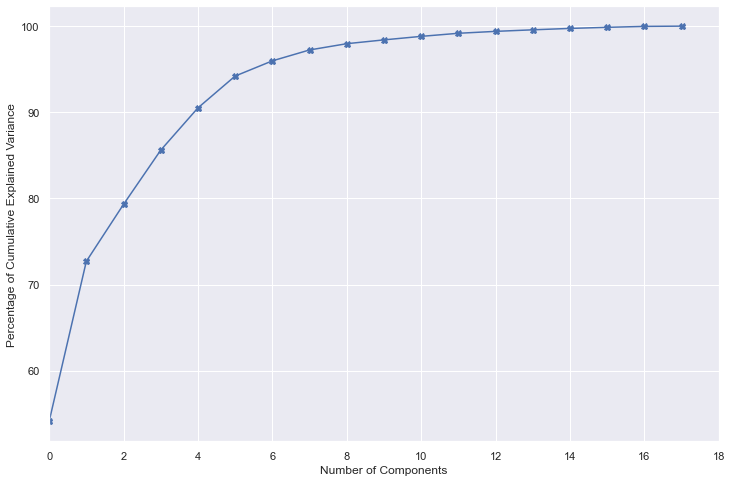

In [20]:
#plotting the cummulative variance explained by the principal componets
pca = PCA()
X_pca_ = pca.fit_transform(XScaled)
plt.figure(figsize = (12, 8))
plt.plot((np.cumsum(pca.explained_variance_ratio_) * 100), marker = 'X')
plt.xlim(0, 18)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Cumulative Explained Variance');

In [21]:
print(pca.explained_variance_)

[9.74940269e+00 3.35071912e+00 1.19238155e+00 1.13381916e+00
 8.83997312e-01 6.66265745e-01 3.18150910e-01 2.28179142e-01
 1.31018595e-01 7.98619108e-02 7.33979478e-02 6.46162669e-02
 4.01448646e-02 3.22758478e-02 2.93936408e-02 2.27005257e-02
 1.98136761e-02 5.16287320e-03]


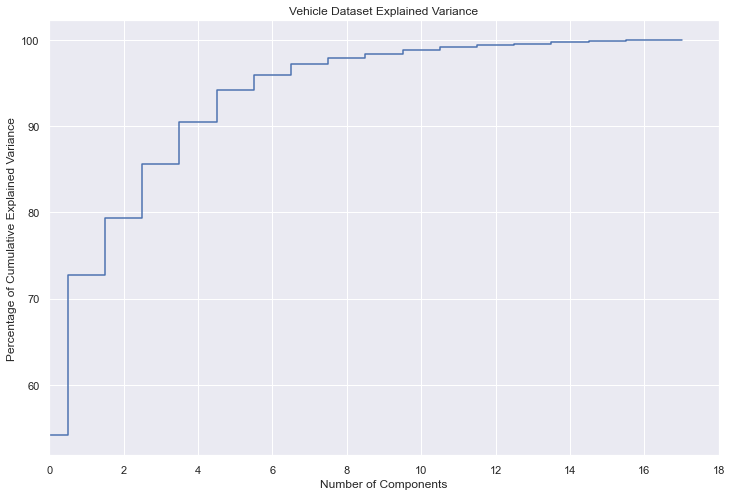

In [22]:
plt.figure(figsize = (12, 8))
plt.step(list(range(18)), (np.cumsum(pca.explained_variance_ratio_) * 100), where = 'mid')
plt.xlim(0, 18)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Cumulative Explained Variance')
plt.title('Vehicle Dataset Explained Variance');

We can see that the first six components explain more than 95% of variation. Between first 5 components, more than 91% of the information is captured. The above plot shows almost 95% variance by the first 6 components. Therefore we can drop 7th component onwards.

In [23]:
#Using 6 components and printing the eigen vectors
pca3 = PCA(n_components=6)
pca3.fit(XScaled)
print(pca3.components_)
print(pca3.explained_variance_ratio_)
Xpca3 = pca3.transform(XScaled)

[[ 0.27250289  0.28725469  0.30242111  0.26971354  0.09786073  0.19520014
   0.31052393 -0.3090069   0.307287    0.27815416  0.29976509  0.30553237
   0.26323762 -0.04193594  0.03608321  0.05872048  0.03801314  0.08474   ]
 [-0.08704358  0.13162176 -0.04614301 -0.19793126 -0.25783995 -0.10804563
   0.07528535 -0.01322994  0.0875602   0.12215424  0.07726575  0.07150302
   0.21058205  0.50362158 -0.01576632 -0.09274624 -0.50162122 -0.50761211]
 [-0.03818521 -0.20114691  0.06346211  0.05628517 -0.06199275 -0.14895782
   0.10904283 -0.09085269  0.1060705  -0.21368469  0.1445998   0.11034373
  -0.20287019  0.07386402 -0.55917399  0.6706805  -0.06224071 -0.04170535]
 [ 0.13867501 -0.03805548  0.10895429 -0.25435509 -0.61276572  0.27867816
   0.00539295  0.06521486  0.03089915  0.04146747 -0.06400509 -0.00219687
  -0.08553965 -0.11539962  0.47370331  0.42842603 -0.0274096   0.09603749]
 [ 0.13710147 -0.13899555 -0.08001743  0.13374437  0.12360146 -0.63489336
   0.08555746 -0.07907344  0.08164

In [24]:
#printing the original features and the reduced features
pca_6 = PCA(n_components = 6)
X_pca = pca_6.fit_transform(XScaled)
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 18
Reduced number of features: 6


In [25]:
#viewing the first 5 observations of the pca components
pca_df = pd.DataFrame(data = X_pca)
pca_df.head()

,0,1,2,3,4,5
0,0.584228,-0.675673,-0.453334,-0.750656,-0.777515,-1.848809
1,-1.512180,-0.348934,-0.333436,1.268953,-0.324929,-0.118317
2,3.913448,0.234507,-1.265094,0.137224,0.915751,-0.685594
3,-1.535193,-3.044413,-0.469623,0.324317,-0.611590,0.367777
4,-0.642062,1.488882,-0.246288,-0.550939,0.471655,-1.012697


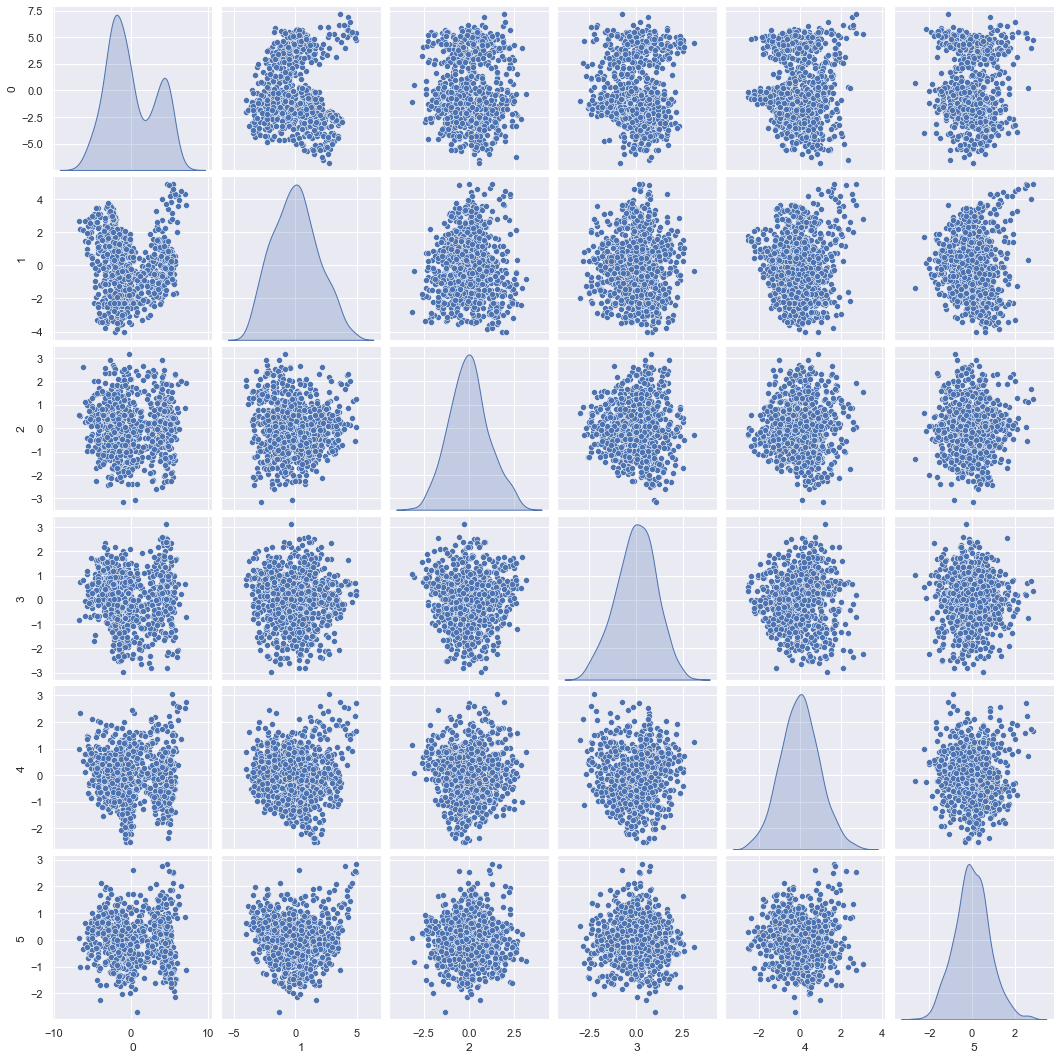

In [26]:
sns.pairplot(pca_df, diag_kind = 'kde');

# SVM

In [27]:
#splitting the original data into train and test 70:30
X_train, X_test, y_train, y_test = train_test_split(XScaled, y, test_size = 0.3, random_state = 10)

In [28]:
rtr, ctr = X_train.shape
print('The training set comprises of', rtr, 'rows and', ctr, 'columns.')

The training set comprises of 592 rows and 18 columns.


In [29]:
rt, ct = X_test.shape
print('The test set comprises of', rt, 'rows and', ct, 'columns.')

The test set comprises of 254 rows and 18 columns.


In [30]:
#splitting the pca data into train and test 70:30
X_tr, X_te, y_tr, y_te = train_test_split(X_pca, y, test_size = 0.3, random_state = 10)

In [31]:
rtr_pca, ctr_pca = X_tr.shape
print('The PCA training set comprises of', rtr_pca, 'rows and', ctr_pca, 'columns.')

The PCA training set comprises of 592 rows and 6 columns.


In [32]:
rt_pca, ct_pca = X_te.shape
print('The PCA test set comprises of', rt_pca, 'rows and', ct_pca, 'columns.')

The PCA test set comprises of 254 rows and 6 columns.


In [33]:
# Building a Support Vector Machine on train data
svc_model = SVC(C= 4, kernel='rbf', gamma='scale')
svc_model.fit(X_train, y_train)

SVC(C=4)

In [34]:
#predicting on train data
sv_train_predict = svc_model .predict(X_train)
print("Model Accuracy on train: {0:.4f}".format(metrics.accuracy_score(y_train, sv_train_predict)))
print()

Model Accuracy on train: 0.9899



In [35]:
#predicting on test data
sv_test_predict = svc_model .predict(X_test)
print("Model Accuracy on test: {0:.4f}".format(metrics.accuracy_score(y_test, sv_test_predict)))
print()

Model Accuracy on test: 0.9685



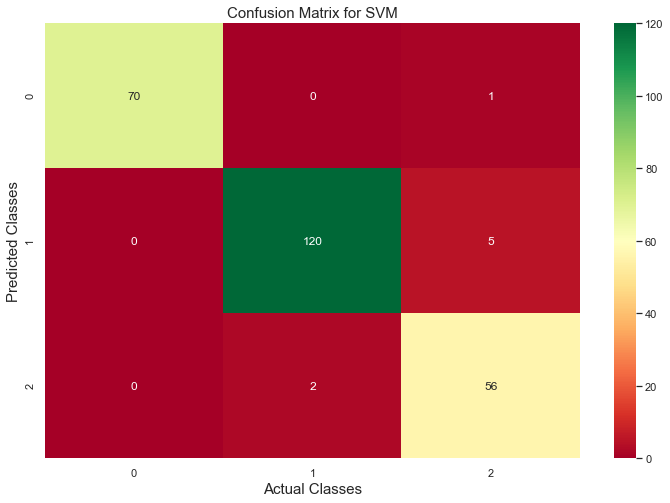

In [36]:
#visualization of confusion matrix in the form of a heatmap
cm= confusion_matrix(y_test, sv_test_predict)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVM', fontsize = 15);

In [37]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(y_test, sv_test_predict, labels=[0,1,2]))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        71
           1       0.98      0.96      0.97       125
           2       0.90      0.97      0.93        58

    accuracy                           0.97       254
   macro avg       0.96      0.97      0.97       254
weighted avg       0.97      0.97      0.97       254



In [38]:
precision_SV, recall_SV, f1_score_SV, support = precision_recall_fscore_support(y_test, sv_test_predict,average='macro')
print('Precision Score :', '%0.2f' % precision_SV)
print('Recall Score :', '%0.2f' % recall_SV)
print('F1-Score:', '%0.2f' % f1_score_SV)
SV_Acc= accuracy_score(y_test, sv_test_predict)
print('Accuracy Score :','%0.2f' % SV_Acc)

Precision Score : 0.96
Recall Score : 0.97
F1-Score: 0.97
Accuracy Score : 0.97


In [39]:
#SVM on the pca data
svc_model_pca = SVC(C= 4, kernel='rbf', gamma='scale')
svc_model_pca.fit(X_tr, y_tr)

SVC(C=4)

In [40]:
#predicting on train data
sv_tr_predict = svc_model_pca .predict(X_tr)
print("Model Accuracy on train: {0:.4f}".format(metrics.accuracy_score(y_tr, sv_tr_predict)))
print()

Model Accuracy on train: 0.9476



In [41]:
#predicting on test data
sv_te_predict = svc_model_pca .predict(X_te)
print("Model Accuracy on test: {0:.4f}".format(metrics.accuracy_score(y_te, sv_te_predict)))
print()

Model Accuracy on test: 0.9213



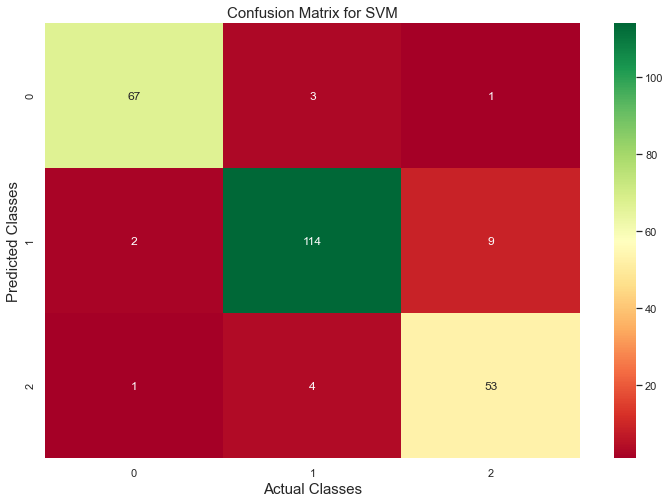

In [42]:
#visualization of confusion matrix in the form of a heatmap
cm= confusion_matrix(y_te, sv_te_predict)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVM', fontsize = 15);

In [43]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(y_te, sv_te_predict, labels=[0,1,2]))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        71
           1       0.94      0.91      0.93       125
           2       0.84      0.91      0.88        58

    accuracy                           0.92       254
   macro avg       0.91      0.92      0.92       254
weighted avg       0.92      0.92      0.92       254



In [44]:
precision_SV_pca, recall_SV_pca, f1_score_SV_pca, support_pca = precision_recall_fscore_support(y_te, sv_te_predict,average='macro')
print('Precision Score :', '%0.2f' % precision_SV_pca)
print('Recall Score :', '%0.2f' % recall_SV_pca)
print('F1-Score:', '%0.2f' % f1_score_SV_pca)
SV_Acc_pca= accuracy_score(y_te, sv_te_predict)
print('Accuracy Score :','%0.2f' % SV_Acc_pca)

Precision Score : 0.91
Recall Score : 0.92
F1-Score: 0.92
Accuracy Score : 0.92


In [45]:
modellists = []
modellists.append(['Support Vector Classifier without PCA', SV_Acc * 100, recall_SV * 100, precision_SV * 100,f1_score_SV*100])
modellists.append(['Support Vector Classifier with PCA', SV_Acc_pca* 100, recall_SV_pca * 100, precision_SV_pca * 100,f1_score_SV_pca*100])
mdl_df = pd.DataFrame(modellists, columns = ['Model','Accuracy Score of Test Data', 'Recall Score', 'Precision Score','F1 Score'])
mdl_df

,Model,Accuracy Score of Test Data,Recall Score,Precision Score,F1 Score
0,Support Vector Classifier without PCA,96.850394,97.047758,96.227745,96.596702
1,Support Vector Classifier with PCA,92.125984,92.315169,91.352049,91.773898


Both the models give more than 90% accuracy on the test data, PCA used only 6 attributes to come up with an accuracy of 90% plus, where as the model without PCA used all the variables to come up with 90% plus accuracy, the difference could have been even better had the dataset been cursed with dimensionality. Since there are 18 variables in the original data therefore the difference is very subtle.

# Part Four

In [1]:
import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing the data
bb=pd.read_csv('Part4 - batting_bowling_ipl_bat.csv')
bb=bb.dropna(axis=0)
bb.head()

,Name,Runs,Ave,SR,Fours,Sixes,HF
1,CH Gayle,733.0,61.08,160.74,46.0,59.0,9.0
3,G Gambhir,590.0,36.87,143.55,64.0,17.0,6.0
5,V Sehwag,495.0,33.00,161.23,57.0,19.0,5.0
7,CL White,479.0,43.54,149.68,41.0,20.0,5.0
9,S Dhawan,569.0,40.64,129.61,58.0,18.0,5.0


# EDA

In [3]:
#checking for the dimension of the data
rows, column = bb.shape
print('The dataset contains', rows, 'rows and', column, 'columns.')

The dataset contains 90 rows and 7 columns.


In [4]:
#checking for the data type
print('The data type of each attribute: \n')
bb.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 1 to 179
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    90 non-null     object 
 1   Runs    90 non-null     float64
 2   Ave     90 non-null     float64
 3   SR      90 non-null     float64
 4   Fours   90 non-null     float64
 5   Sixes   90 non-null     float64
 6   HF      90 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


In [5]:
#5-point summary
bb.describe().T

,count,mean,std,min,25%,50%,75%,max
Runs,90.0,219.933333,156.253669,2.00,98.000,196.500,330.7500,733.00
Ave,90.0,24.729889,13.619215,0.50,14.665,24.440,32.1950,81.33
SR,90.0,119.164111,23.656547,18.18,108.745,120.135,131.9975,164.10
Fours,90.0,19.788889,16.399845,0.00,6.250,16.000,28.0000,73.00
Sixes,90.0,7.577778,8.001373,0.00,3.000,6.000,10.0000,59.00
HF,90.0,1.188889,1.688656,0.00,0.000,0.500,2.0000,9.00


In [6]:
print('Duplicated rows: ', bb[bb.duplicated()].shape[0])

Duplicated rows:  0


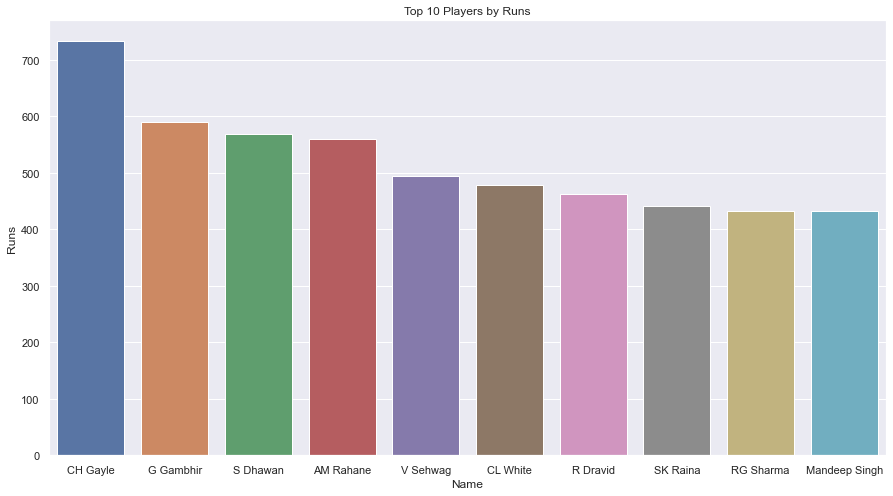

In [7]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Runs'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Runs']
sns.barplot(data= b1 , x= 'Name' , y ='Runs');
plt.title("Top 10 Players by Runs");

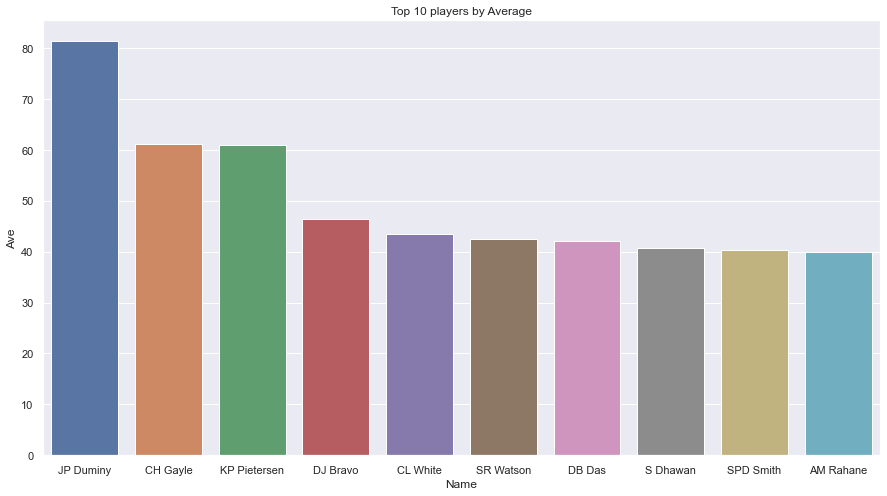

In [8]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Ave'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Ave']
sns.barplot(data= b1 , x= 'Name' , y ='Ave')
plt.title("Top 10 players by Average");

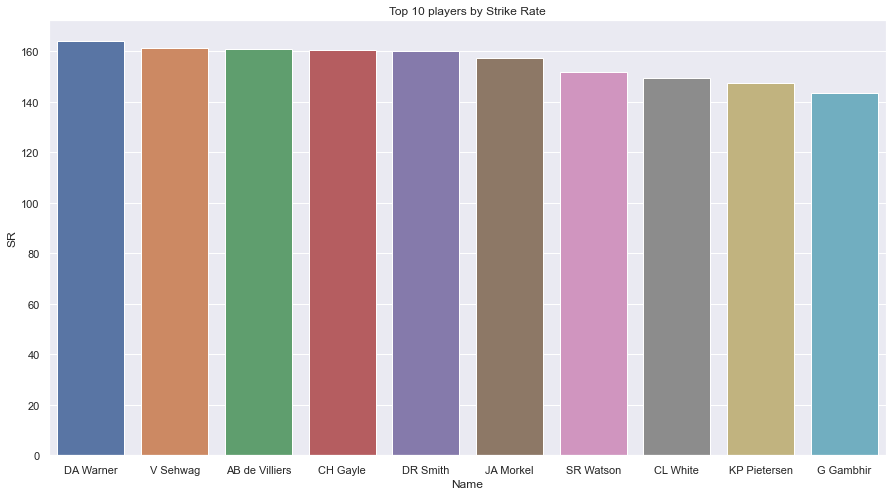

In [9]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['SR'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'SR']
sns.barplot(data= b1 , x= 'Name' , y ='SR')
plt.title("Top 10 players by Strike Rate");

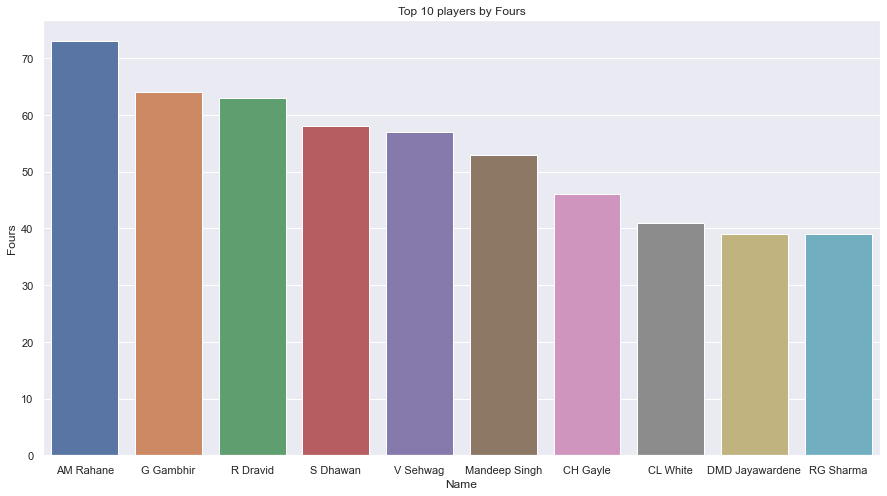

In [10]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Fours'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Fours']
sns.barplot(data= b1 , x= 'Name' , y ='Fours')
plt.title("Top 10 players by Fours");

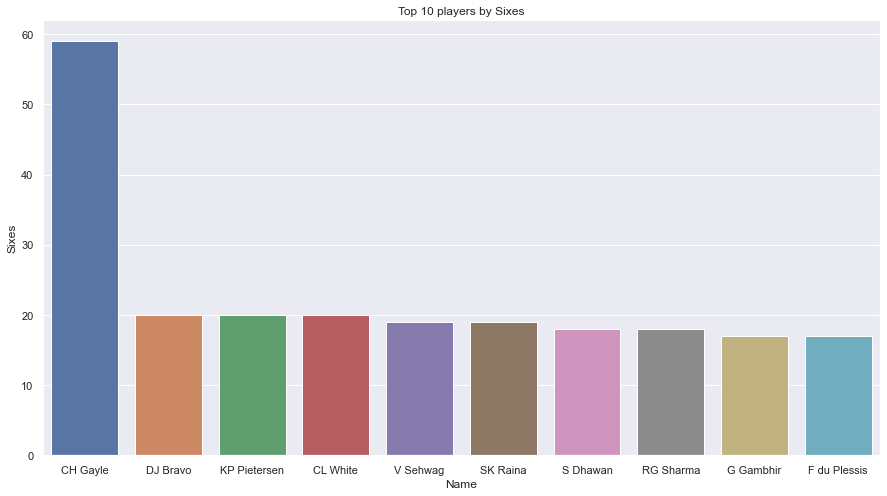

In [11]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Sixes'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Sixes']
sns.barplot(data= b1 , x= 'Name' , y ='Sixes')
plt.title("Top 10 players by Sixes");

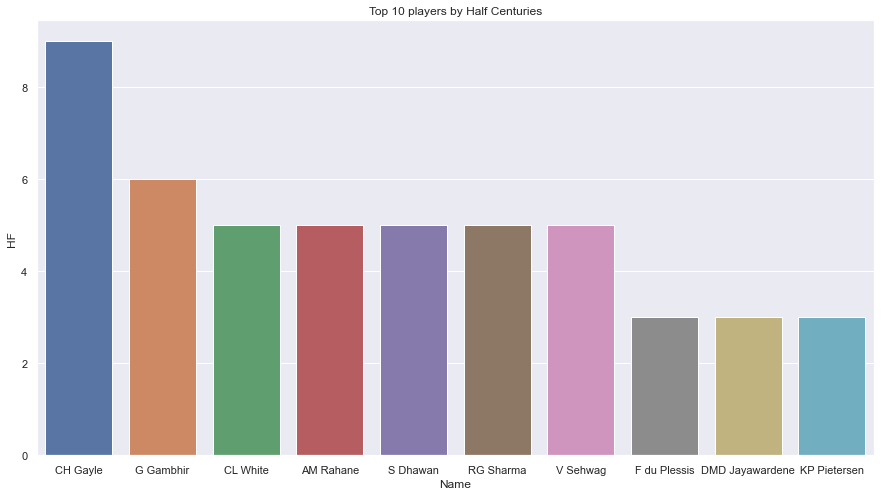

In [12]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['HF'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'HF']
sns.barplot(data= b1 , x= 'Name' , y ='HF')
plt.title("Top 10 players by Half Centuries");

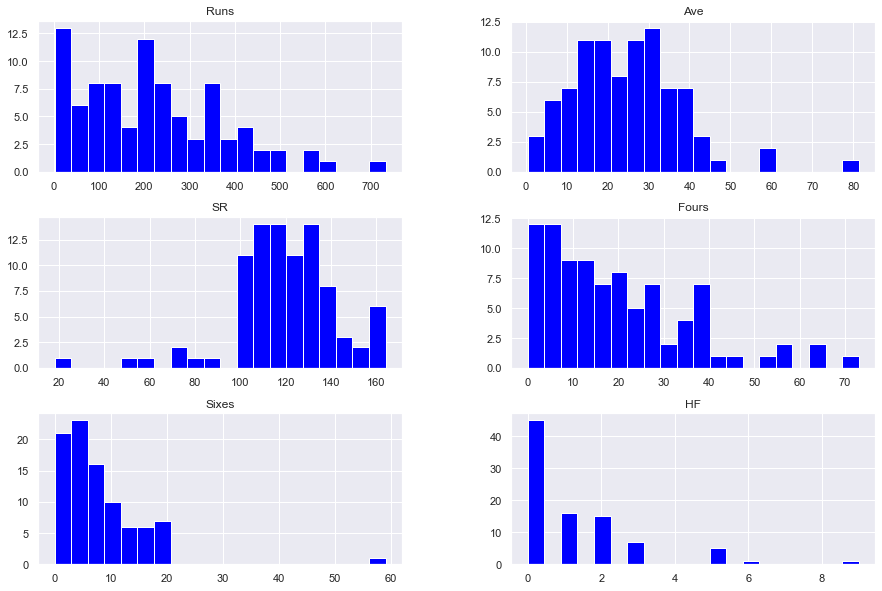

In [13]:
bb.hist(bins = 20, figsize = (15, 10), color = 'blue')
plt.show()

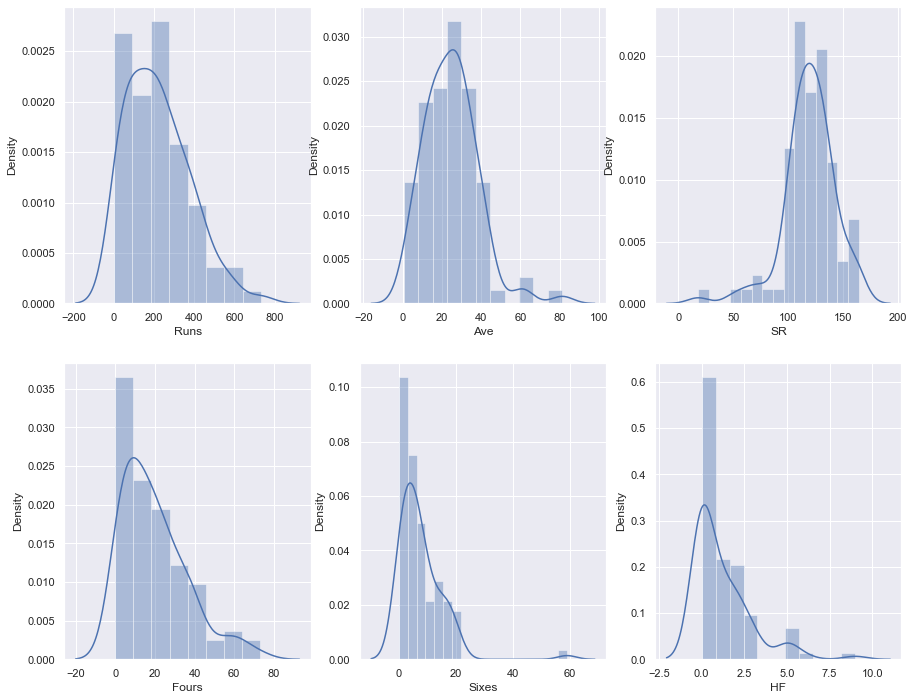

In [14]:
plt.figure(figsize=(15, 12))
col = 1
for i in bb.drop(columns='Name').columns:
    plt.subplot(2, 3, col)
    sns.distplot(bb[i], color = 'b')
    col += 1 

Strike rate, fours, sixes and half centuries have a skewed distribution.

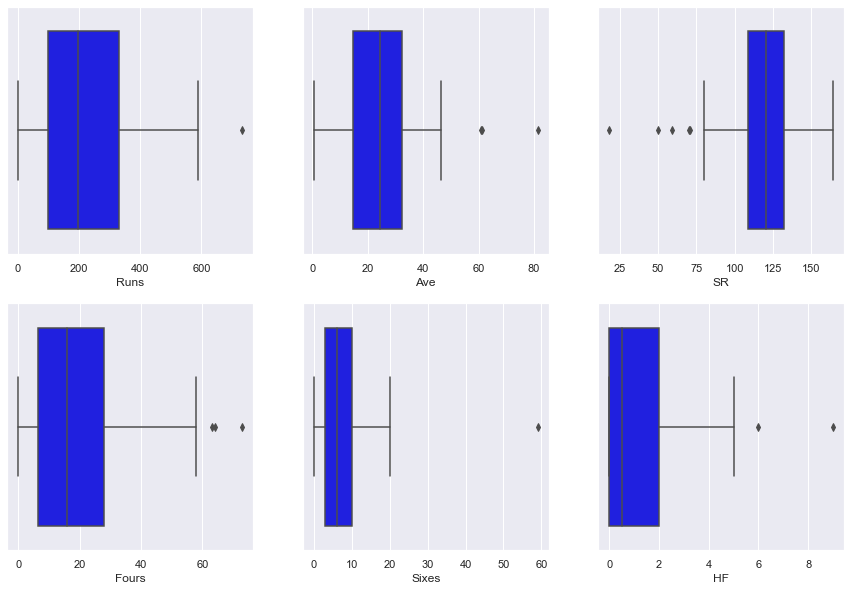

In [15]:
plt.figure(figsize=(15, 10))
col = 1
for i in bb.drop(columns='Name').columns:
    plt.subplot(2, 3, col)
    sns.boxplot(bb[i],color='blue')
    col += 1

There are outliers. Won't be treating them as it is likely that these are genuine observations.

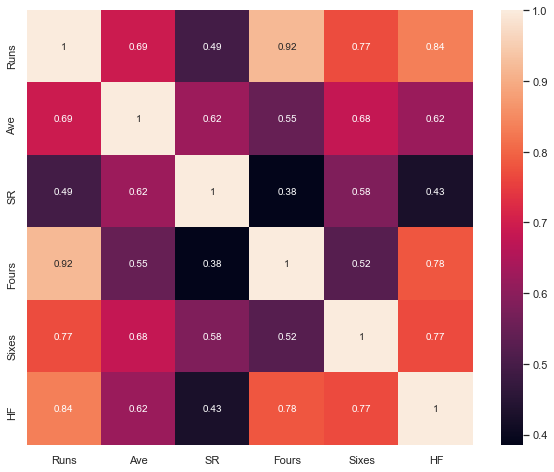

In [16]:
#checking for correlation
plt.figure(figsize=(10,8))
corr=bb.drop(columns='Name').corr()
sns.heatmap(corr,annot=True);

All the variables except fours with strike rate, strike rate with half centuries,strike rate with runs, have high correlation.

In [17]:
#scaling the numeric variables
cc = bb.iloc[:,1:7] 
cc1 = cc.apply(zscore)
cc1.head()

,Runs,Ave,SR,Fours,Sixes,HF
1,3.301945,2.683984,1.767325,1.607207,6.462679,4.651551
3,2.381639,0.896390,1.036605,2.710928,1.184173,2.865038
5,1.770248,0.610640,1.788154,2.281703,1.435530,2.269533
7,1.667276,1.388883,1.297182,1.300618,1.561209,2.269533
9,2.246490,1.174755,0.444038,2.343021,1.309851,2.269533


In [18]:
#checking for the within sum of squares
wss =[] 
for i in range(1,6):
    KM = KMeans(n_clusters=i)
    KM.fit(cc1)
    wss.append(KM.inertia_)
wss

[540.0000000000001,
 296.26135354732025,
 223.36518460916952,
 178.1750796759041,
 144.68430051153075]

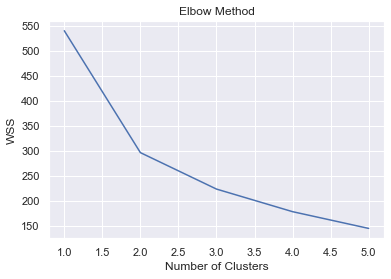

In [19]:
#plotting to check for optimal clustres 
plt.plot(range(1,6), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");

In [20]:
#using 2 centroids
k_means = KMeans(n_clusters = 2)
k_means.fit(cc1)
labels = k_means.labels_

In [21]:
# Calculating silhouette_score
silhouette_score(cc1,labels)

0.41111085574076756

In [22]:
#plotting silhouette score for different centroids
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}


silhouette_coefficients = []

 # Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cc1)
    score = silhouette_score(cc1,kmeans.labels_)
    silhouette_coefficients.append(score)

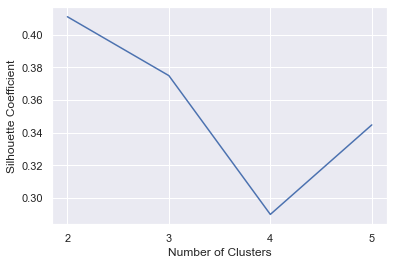

In [23]:
plt.plot(range(2,6), silhouette_coefficients)
plt.xticks(range(2, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [24]:
#attaching the labels to the original data
bb['cluster']=labels
bb.head()

,Name,Runs,Ave,SR,Fours,Sixes,HF,cluster
1,CH Gayle,733.0,61.08,160.74,46.0,59.0,9.0,0
3,G Gambhir,590.0,36.87,143.55,64.0,17.0,6.0,0
5,V Sehwag,495.0,33.00,161.23,57.0,19.0,5.0,0
7,CL White,479.0,43.54,149.68,41.0,20.0,5.0,0
9,S Dhawan,569.0,40.64,129.61,58.0,18.0,5.0,0


In [25]:
#veiwing the distribution of the clusters
bb.cluster.value_counts().sort_index()

0    35
1    55
Name: cluster, dtype: int64

In [26]:
#aggregating the clusters with the numeric variables with their mean
aggdata=bb.iloc[:,0:9].groupby('cluster').mean()
aggdata['Freq']=bb.cluster.value_counts().sort_index()
aggdata

,Runs,Ave,SR,Fours,Sixes,HF,Freq
cluster,,,,,,,
0,372.657143,35.962286,132.808286,34.685714,13.771429,2.714286,35
1,122.745455,17.582000,110.481455,10.309091,3.636364,0.218182,55


In [27]:
#based on the above table renaming/ranking the playes in Grade A and Grade B
bb['cluster'] = bb['cluster'].replace({0: 'Grade A', 1: 'Grade B'})

In [28]:
#list of Grade A players
Grade_A = bb[bb['cluster'] == 'Grade A']
Grade_A.head(10)

,Name,Runs,Ave,SR,Fours,Sixes,HF,cluster
1,CH Gayle,733.0,61.08,160.74,46.0,59.0,9.0,Grade A
3,G Gambhir,590.0,36.87,143.55,64.0,17.0,6.0,Grade A
5,V Sehwag,495.0,33.00,161.23,57.0,19.0,5.0,Grade A
7,CL White,479.0,43.54,149.68,41.0,20.0,5.0,Grade A
9,S Dhawan,569.0,40.64,129.61,58.0,18.0,5.0,Grade A
11,AM Rahane,560.0,40.00,129.33,73.0,10.0,5.0,Grade A
13,KP Pietersen,305.0,61.00,147.34,22.0,20.0,3.0,Grade A
15,RG Sharma,433.0,30.92,126.60,39.0,18.0,5.0,Grade A
17,AB de Villiers,319.0,39.87,161.11,26.0,15.0,3.0,Grade A
19,JP Duminy,244.0,81.33,128.42,13.0,11.0,2.0,Grade A


In [29]:
#list of Grade B players
Grade_B = bb[bb['cluster'] == 'Grade B']
Grade_B.head()

,Name,Runs,Ave,SR,Fours,Sixes,HF,cluster
69,MS Bisla,213.0,30.42,133.12,16.0,10.0,1.0,Grade B
73,BJ Hodge,245.0,30.62,140.00,18.0,9.0,0.0,Grade B
75,NV Ojha,255.0,23.18,113.83,21.0,13.0,1.0,Grade B
77,DB Das,126.0,42.00,135.48,9.0,6.0,0.0,Grade B
79,AC Gilchrist,172.0,34.40,120.27,21.0,4.0,1.0,Grade B


In [30]:
#metric for ranking players.
bb['metric']=(bb['Runs']/bb['Ave'])*bb['SR']

In [31]:
#Sorting by metric.
bbs=bb.sort_values(by=['metric'], ascending=False)

In [32]:
#Ranked with respect to index values where index=0 is the best player and index=89 is the worst.
bbs = bbs.reset_index(drop=True)

In [33]:
bbs.head(60)

,Name,Runs,Ave,SR,Fours,Sixes,HF,cluster,metric
0,V Sehwag,495.0,33.00,161.23,57.0,19.0,5.0,Grade A,2418.450000
1,SK Raina,441.0,25.94,135.69,36.0,19.0,1.0,Grade A,2306.834618
2,G Gambhir,590.0,36.87,143.55,64.0,17.0,6.0,Grade A,2297.111473
3,Mandeep Singh,432.0,27.00,126.31,53.0,7.0,2.0,Grade A,2020.960000
4,CH Gayle,733.0,61.08,160.74,46.0,59.0,9.0,Grade A,1928.985265
5,S Dhawan,569.0,40.64,129.61,58.0,18.0,5.0,Grade A,1814.667569
6,AM Rahane,560.0,40.00,129.33,73.0,10.0,5.0,Grade A,1810.620000
7,R Dravid,462.0,28.87,112.13,63.0,4.0,2.0,Grade A,1794.390717
8,RG Sharma,433.0,30.92,126.60,39.0,18.0,5.0,Grade A,1772.891332
9,RV Uthappa,405.0,27.00,118.07,38.0,10.0,2.0,Grade A,1771.050000


In [34]:
bbs.tail(30)

,Name,Runs,Ave,SR,Fours,Sixes,HF,cluster,metric
60,RE Levi,83.0,13.83,113.69,10.0,4.0,1.0,Grade B,682.304411
61,DR Smith,157.0,39.25,160.20,18.0,7.0,1.0,Grade A,640.800000
62,Y Venugopal Rao,132.0,22.00,104.76,8.0,5.0,0.0,Grade B,628.560000
63,MJ Clarke,98.0,16.33,104.25,12.0,0.0,0.0,Grade B,625.627679
64,SL Malinga,55.0,9.16,103.77,4.0,3.0,0.0,Grade B,623.073144
65,DT Christian,145.0,29.00,122.88,8.0,6.0,0.0,Grade B,614.400000
66,AC Gilchrist,172.0,34.40,120.27,21.0,4.0,1.0,Grade B,601.350000
67,Y Nagar,153.0,30.60,115.03,13.0,3.0,0.0,Grade B,575.150000
68,R Vinay Kumar,68.0,13.60,109.67,3.0,2.0,0.0,Grade B,548.350000
69,STR Binny,90.0,22.50,134.32,9.0,3.0,0.0,Grade B,537.280000


# Part Five

### List of all possible dimensionality reduction techniques that can be implemented using python.

### Dimensionality reduction techniques can be classified into two 3 types:

### 1) Feature selection:

a) Missing Value Ratio: If the dataset has too many missing values, we use this approach to reduce the number of variables. We can drop the variables having a large number of missing values in them.

b) Low Variance filter: We apply this approach to identify and drop constant variables from the dataset. The target variable is not unduly affected by variables with low variance, and hence these variables can be safely dropped.

c) High Correlation filter: A pair of variables having high correlation increases multicollinearity in the dataset. So, we can use this technique to find highly correlated features and drop them accordingly.

d) Random Forest: This is one of the most commonly used techniques which tells us the importance of each feature present in the dataset. We can find the importance of each feature and keep the top most features, resulting in dimensionality reduction.

e) Both Backward Feature Elimination and Forward Feature Selection techniques take a lot of computational time and are thus generally used on smaller datasets.

### 2) Components / Factor Based:

a) Factor Analysis: This technique is best suited for situations where we have highly correlated set of variables. It divides the variables based on their correlation into different groups, and represents each group with a factor.

b) Principal Component Analysis: This is one of the most widely used techniques for dealing with linear data. It divides the data into a set of components which try to explain as much variance as possible.

c) Independent Component Analysis: We can use ICA to transform the data into independent components which describe the data using less number of components.

### 3) Projection Based:

a) ISOMAP: We use this technique when the data is strongly non-linear.

b) t-SNE: This technique also works well when the data is strongly non-linear. It works extremely well for visualizations as well.

c) UMAP: This technique works well for high dimensional data. Its run-time is shorter as compared to t-SNE.

### Application of Dimensionality Reduction

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

The images data is a three-dimensional array: 1,797 samples, each consisting of an 8×8 grid of pixels.

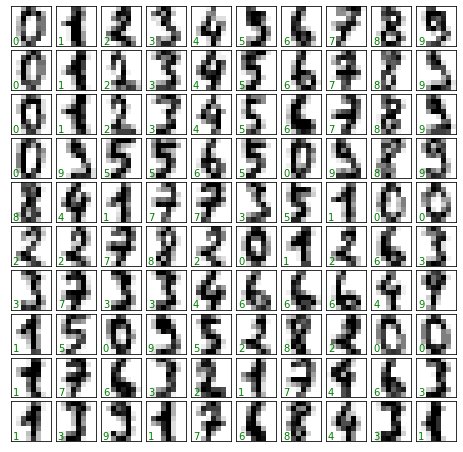

In [2]:
# visualize the first hundred of these
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
subplot_kw={'xticks':[], 'yticks':[]},
gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i,ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
    transform=ax.transAxes, color='green')

In [3]:
#two-dimensional,[n_samples, n_features] representation
X = digits.data
Xi = digits.images
X.shape

(1797, 64)

In [4]:
y = digits.target
y.shape

(1797,)

1,797 samples and 64 features.

In [5]:
#transform the data to two dimensions using manifold learning algorithm called Isomap
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

The projected data is now two-dimensional

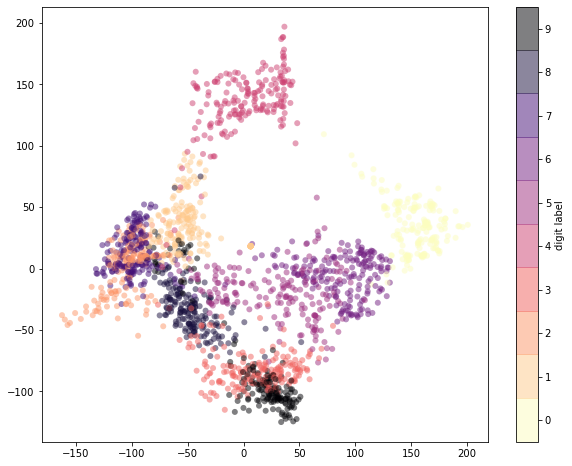

In [6]:
# plot this data to see if we can learn anything from its structure 
plt.figure(figsize=(10, 8))
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('magma_r', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

In [7]:
from sklearn.model_selection import train_test_split
 # Split X and y into training and test set in 70:30 ratio

X_train, X_test, Xi_train, Xi_test, y_train, y_test = train_test_split(X, Xi, y, test_size=0.30, random_state=15)

In [8]:
#fit a Gaussian naive Bayes model
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [9]:
# gauge its accuracy by comparing the true values of the test set to the predictions
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.8407407407407408

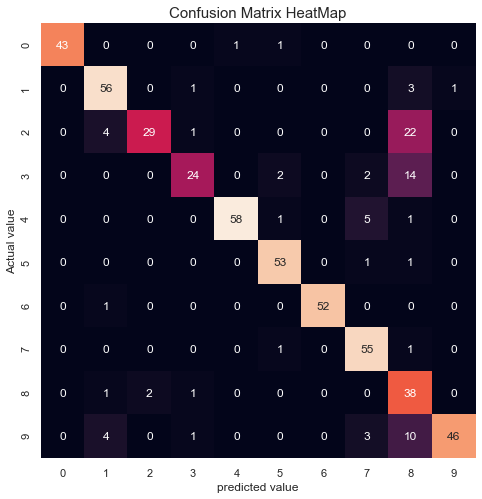

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
#visualization of confusion matrix in the form of a heatmap
plt.figure(figsize = (12, 8))
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('Actual value');
plt.title('Confusion Matrix HeatMap', fontsize = 15);

This shows us where the mislabeled points tend to be. For Example: A large number of twos here are misclassified as either ones or eights.

Another way to gain intuition into the characteristics of the model is to plot the inputs again, with their predicted labels. We’ll use green for correct labels, and red for incorrect labels.

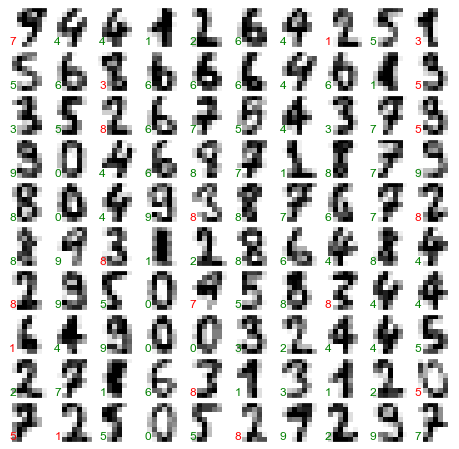

In [11]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(Xi_test[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(pred[i]),
    transform=ax.transAxes,
    color='green' if (y_test[i] == pred[i]) else 'red')